# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

## Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα

| Team 10                              |          |
|--------------------------------------|----------|
| Ανδρεάς Χρυσοβαλάντης - Κωνσταντίνος | 03118102 |
| Μανίατης Ανδρέας                     | 03118070 |
| Παπανικολάου Ιωάννης                 | 03118064 |

In [9]:
#!pip install --upgrade pip
#!pip install --upgrade numpy
#!pip install --upgrade pandas
#!pip install --upgrade nltk
#!pip install --upgrade scikit-learn
#!pip install --upgrade joblib
import numpy as np
import pandas as pd

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [10]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [11]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 10

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [5]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Hell Is for Heroes']



['"Anti-war",  "Action",  "Anti-war film",  "Combat Films",  "War film"']



[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.



 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

**Για την εύρεση domain-specific λέξεων-κλειδιών(stopwords) θα επιθεωρήσουμε όλο το dataset(δηλαδή για όλα τα seeds) για να βρούμε τις πιο δημοφιλείς λέξεις αφού αφαιρέσουμε τις κοινές λέξεις-κλειδιά.**

In [12]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package omw-1.4 is already up-to-date!

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!

[nltk_data] Downloading package rslp to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package rslp is already up-to-date!

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#συναρτήσεις από notebook μαθήματος

#χρησιμοποείται για να φιλτράρουμε λέξεις που αποτελούνται μόνο από punctuation symbols πχ. '???' ή '...'

def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

#συνολικό φιλτράρισμα
#για το φιλτράρισμα χρησιμοποιούμε μόνο lemmatizer!

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    cnt = collections.Counter(lemmatized_words)
    return cnt

In [12]:
from tqdm.auto import tqdm
from collections import Counter
import collections
# empty Counter
counter = Counter()

#22301 film summaries
for i in tqdm(df_data_1.iloc[:, [5]].values[:]):
    counter += preprocess_document(i[0])

counter

  0%|          | 0/22302 [00:00<?, ?it/s]

Counter({'set': 4770,
         'second': 1915,
         'half': 757,
         '22nd': 7,
         'century': 462,
         'film': 11643,
         'depicts': 192,
         'mar': 208,
         'planet': 719,
         '84': 7,
         'terraformed': 1,
         'allowing': 466,
         'human': 1790,
         'walk': 2207,
         'surface': 392,
         'without': 2465,
         'wearing': 643,
         'pressure': 436,
         'suit': 429,
         'martian': 119,
         'society': 804,
         'become': 3755,
         'largely': 104,
         'matriarchal': 4,
         'woman': 7668,
         'position': 777,
         'authority': 686,
         'story': 6166,
         'concern': 365,
         'police': 7271,
         'officer': 2974,
         'melanie': 136,
         'ballard': 45,
         'command': 591,
         'small': 2433,
         'team': 3098,
         'alongside': 134,
         'sergeant': 408,
         'jericho': 56,
         'sent': 1930,
         'pick': 1145,
  

**Ελέγχουμε τις μεγάλες συμβολοσειρές για να δούμε αν μας ξέφυγε κάτι όπως για παράδειγμα links.**

In [13]:
j=0
for i in counter:
    if j ==20:
        break
    elif len(i)>20:
        print(i)
        j += 1

female-dominant/male-submissive



supercalifragilisticexpialidocious



employers—aggressively



wicked-super-dyke-from-hell



director/producer/screenwriter



astronaut-in-training



//www.tcm.com/tcmdb/title/81715/the-lone-wolf-meets-a-lady/



//movies.nytimes.com/movie/review



res=9902efd7163fe03abc4851dfb4678383659ede



//www.hmsrichmond.org/dict_b.htm



|titlehmsrichmond.org



//www.imdb.com/title/tt0023512/



sight-and-hearing-impaired



//amarbondhurashed.com/index.html



nameelley|firstcyrano



agency|url2141|publisher2012-06-14



//www.filmaffinity.com/es/film158004.html



//www.allmovie.com/work/squibs-111526



//www.seinology.com/scripts/script-01.shtml



//www.first14.com/bhopal-gas-tragedy-92-injuries-termed-minor-822.html|accessdatefirst14


In [14]:
for i in counter:
    if len(i)>20 and "www" not in i and ".com" not in i and "//" not in i and "|" not in i: print(i,"\n")

female-dominant/male-submissive 







supercalifragilisticexpialidocious 







employers—aggressively 







wicked-super-dyke-from-hell 







director/producer/screenwriter 







astronaut-in-training 







res=9902efd7163fe03abc4851dfb4678383659ede 







sight-and-hearing-impaired 







performance-enhancing 







hairdresser-turned-drag 







not-especially-discriminating 







refined-yet-dishonest 







twenty-seven-year-old 







playboy/private-investigator 







assignment-recreating 







vastaav.circumstances 







not-so-merry-old-england 







name/19750101/reviews/501010323/1023 







mechanically-operated 







cmd11-52-32-4-14-2011-9429 







spezialeinsatzkommando 







it's-midnight-and-everything-comes-to-life 







scared-out-of-his-wits 







/20101221/reviews/101229995 







p_text_direct-0document_id 







s_trackvalc24saaaaibaj 







q=nbff-day-5-my-run-sicilian-girl 







pidd5b87c29-63e1-4cc5-8a25-9524ade359b

In [15]:
for i in counter:
     if len(i)>20 and  "|" in i: print(i,"\n")
print("-----------")
for i in counter:
     if len(i)<15 and  "|" in i: print(i,"\n")

|titlehmsrichmond.org 







nameelley|firstcyrano 







agency|url2141|publisher2012-06-14 







//www.first14.com/bhopal-gas-tragedy-92-injuries-termed-minor-822.html|accessdatefirst14 







//latimesblogs.latimes.com/movies/2011/09/ed-helms-jason-segel-jeff-who-lives-at-home-duplass-brothers-sarandon-reviews-toronto.html|accessdatethe 







|title2010-01-18|languagekinema 







|date2010-01-18|publisherhttp 







//ftvdb.bfi.org.uk/sift/title/305846|title2010-01-18|publisher=british 







|title2008-09-19|work=ny 







namebartlet|firstrwanda 







mémoire|accessdateafricultures|url2824 







goode|mediumlionsgate 







//www.kollywoodtoday.net/news/no-more-violence-says-renigunta-director-panneerselvam/|titlekollywoodtoday.net 







dirty-dancing-coverx-large.jpg|left|thumb|an 







guardian|accessdatelondon 







sydney_morning_herald|the 







/c/a/1999/04/09/dd62687.dtl| 







//blogs.crikey.com.au/cinetology/2012/03/30/10-terrorists-movie-review

**Αποφασίζουμε να αφαιρέσουμε όλα τα tokens που περιέχουν το '|'.**

**Σχετικά με τα '/' :**

In [16]:
for i in counter:
    if '/' in i and "www" not in i and ".com" not in i and "//" not in i and "|" not in i:
        print(i)

boyfriend/client



worker/madame



female-dominant/male-submissive



ju/'hoansi



san/bushmen



pen/love



director/producer/screenwriter



drama/mystery



bed/cot



cot/metal



teacher/church



1953/54



ernest/joe



parent/teacher



founder/executive



m/sgt



his/her



gangster/sexual



and/or



1/6



fur/hair



banker/real



on-again/off-again



satan/anne



playboy/private-investigator



amina/ananka



alex/louie



review/film



sgt/head



horse/whoa



ball/puck



training/evaluation



director/producer



p-a-x-497/341



la/spca



concrete/cement



arizona/california



name/19750101/reviews/501010323/1023



janitor/food



mayor/sheriff/hair



parvati/gowri



/parvati



poster/banner



lover/boss



writer/reporter



/20101221/reviews/101229995



3/4



11/28



anna/anastasia



30,000/-



alexandre/stavisky



1959/60



ug/tetra



1/2



hideout/drug



owner/occupant



20/20



rich-boy/poor-girl



vhs/dvd



johnny/gyneshwar





**Αποφασίζουμε να κάνουμε split στο σύμβολο '/'**

*Προς το παρόν τα αγνοούμε γιατί θέλουμε να βρούμε μόνο τις πιο δημοφιλείς λέξεις όλου του dataset**

In [17]:
#save dataset counter

with open('counter.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('word,freq\n')
    for tag, count in counter.items():
        fp.write('{},{}\n'.format(tag, count))  

In [18]:
df = pd.read_csv('counter.csv', on_bad_lines='skip')
df2 = df.sort_values('freq',ascending=False)
print(df2.word.values.tolist()[:300])

["'s", 'one', 'find', 'get', 'go', 'take', 'back', 'tell', 'life', 'film', 'father', 'two', 'friend', 'time', 'love', 'man', 'day', 'family', 'home', 'make', 'new', 'try', 'come', 'house', 'see', 'also', 'however', 'later', 'return', 'mother', 'end', 'begin', 'woman', 'help', 'kill', 'meet', 'police', 'away', 'young', 'year', 'girl', 'wife', 'son', 'first', 'child', 'way', 'night', '’', "n't", 'give', 'story', 'escape', 'fall', 'run', 'death', 'work', 'daughter', 'attempt', 'car', 'show', 'becomes', 'start', 'killed', 'money', 'turn', 'brother', 'want', 'next', 'another', 'decides', 'men', 'soon', 'leaf', 'school', 'old', 'order', 'boy', 'set', 'leave', 'group', 'meanwhile', 'plan', 'asks', 'head', 'finally', 'eventually', 'named', 'call', 'fight', 'room', 'town', 'three', 'people', 'say', 'world', 'know', 'still', 'city', 'like', 'together', 'arrives', 'place', 'would', 'attack', 'become', 'around', 'even', 'sister', 'husband', 'local', 'body', 'dead', 'well', 'hand', 'job', 'scene', 

**Προσθέτουμε στα stop-words μερικές λέξεις οι οποίες είναι συχνές στα κινηματογραφικά summaries αλλά δεν προσθέτουν πληροφορία για την ίδια την πλοκή και τις οποίες παρατηρούμε παραπάνω.**

**Μια άλλη ιδέα θα ήταν να αφαιρέσουμε τα κύρια ονόματα πχ. "mary","george" τα οποία επίσης μπορεί να δώσουν αυξημένη ομοιότητα μεταξύ ταινιών χωρίς λόγο**

**Παρατηρούμε επίσης ότι το πιο δημοφιλές token είναι το κτητικό "'s" το οποίο επίσης πρέπει να αφαιρεθεί στη συνέχεια.** 

In [19]:
movies_stop_words = ['film','story','scene','movie','appears','crew','plot','shown','leading',\
                    'career','director','released','audience','performance','actor']

In [ ]:
my_file = open("names.txt", "r")
names_stop_words = []  
lines = my_file.readlines()
for line in lines:
    names_stop_words.append(line[:-1].lower())
names_stop_words[:20]

**Προεπεξεργασία Dataset**

In [16]:
test = "Squad baby/parror it's lead|er's Sgt.  well-deserved weeks. //www.During non-commissioned , \
Serge//ant Pike ,  @ @inclu4de con-man //thief , 88 mechanic-who-can-fix-anything, ([[Nick Adams @! ...   . "

In [17]:
#function to apply to each string of summary
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

#extend stopwords
all_stopwords = set(stopwords.words('english'))
all_stopwords.update(names_stop_words)
all_stopwords.update(movies_stop_words)

def cleaned(s):
    #αφαίρεση κενών
    s = s.strip()
    #πεζά
    s = s.lower()
    s = re.sub(re.compile("\\r\\n"), ' ', s)
    s = re.sub(re.compile("\'s"), ' ', s)
    words = nltk.word_tokenize(s)
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in list(all_stopwords) + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    #αφαίρεση λέξεων που περιέχουν τα κάτωθι
    words = [word for word in filtered_words if "//" not in word and ".com" not in word and "|" not in word]
    #αφαίρεση σύντομων συμβολοσειρών
    words = [word for word in words if len(word) > 3]
    s2 = " ".join(words)
    #αντικατάσταση '/' με κενό
    s2 = re.sub(re.compile("/"), ' ', s2)
    #κρατάμε μόνο χαρακτήρες, γράμματα και κενά
    s2 = re.sub(r"[^a-z0-9A-Z\s]", " ", s2)
    
    #αφαίρεση σύντομων συμβολοσειρών
    s3 = s2.split()
    words = [word for word in s3 if len(word) > 3]
    filtered_s3 = [word for word in words if word not in list(all_stopwords)]

    s4 = " ".join(filtered_s3)
    
    return s4

In [18]:
cleaned(test)

'squad parror well deserved week commissioned pike inclu4de mechanic anything'

In [19]:
from tqdm.auto import tqdm
cleaned_corpus = []
for i in tqdm(corpus, colour='blue'):
    cleaned_corpus.append(cleaned(i))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
with open("cleaned_corpus.txt", "w") as my_file:
    for i in cleaned_corpus:
        my_file.write(i + "\n\n")

NameError: name 'cleaned_corpus' is not defined

In [11]:
empty = set()
for i in cleaned_corpus:
    i = i.split()
    empty.update(i)
print("Corpus for 5000 movies' summaries is: ",len(empty))

Corpus for 5000 movies' summaries is:  42838


In [18]:
with open('cleaned_corpus.txt', 'r') as my_file:
    lines = my_file.readlines()
cleaned_corpus = []
for i in lines:
    if i != '\n':
        cleaned_corpus.append(i)

In [19]:
len(cleaned_corpus)

5000

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(cleaned_corpus)
corpus_tf_idf_plain = vectorizer.transform(cleaned_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [21]:
print(corpus_tf_idf_plain.shape)

(5000, 42838)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest

#, corpus_type

def content_recommender(target_movie, max_recommendations, corpus_type):
    cos_scores = {}
    for i in range(len(titles)):
        cs = cosine_similarity(corpus_type[target_movie], corpus_type[i])
        cos_scores[i] = cs
    
    #exclude own movie
    res = nlargest(max_recommendations+1, cos_scores, key = cos_scores.get)
    
    for (i,j) in enumerate(res):
        if j == target_movie:
            continue
        else:
            print(f"Rank: {i}\n")
            print(f"Cosine similarity score: {cos_scores[j][0][0]}\n")
            print(f"ID: {j}\n")
            print(f"Title: {titles[j][0]}\n")
            print(f"Summary:\n\n{summaries[j][0]}\n")
            print(f"Categories:\n\n{categories[j]}\n")
            print("--------------------------------------------------------------------\n")

**Παρακάτω εκτελούμε μερικά πειράματα για έναν recommender που επιστρέφει 3 πιθανές ταινίες:**

In [23]:
#movie with which we want to find similar ones
j = 61
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")

ID: 61



Title: Don't Come Knocking



Summary:



Shepard stars as Howard Spence, an aging, hard-living Western movie star, who, disgusted with his life, flees by horse from the set of his latest western filming in the desert outside Moab, Utah. He hits the road looking for refuge in his past, traveling to his hometown of Elko, Nevada and, eventually, to Butte, Montana, looking for a woman  he left behind twenty years before when he was filming a movie there. Spence is doggedly pursued by Mr. Sutter , a humorless representative of the company insuring Spence's latest film, whose mission is to return Spence to the set to finish filming the movie. Also converging on Butte is a young woman named Sky , returning her late mother's ashes to her hometown and conducting a search of her own.



Categories:



['"Western",  "Family Drama",  "Drama",  "Indie",  "Musical"']




In [24]:
content_recommender(61,3,corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.11055433054528796



ID: 4964



Title: Out of Step



Summary:



 The film begins with a narration by Jenny Thomas  over scenes of a blonde girl dancing as she grows up. She explains that the two most important things in her life are her dancing and her faith . Her mother  was always pushing her to do well while her father  would stand at the finish line and urge her on. The person to whom she is closest is her father, and this comes up several times during the film. Her mother continues to push her to excel in dance, until Jenny decides to pursue her dance education at NYU, then her mother begins pulling her back. Jenny was expecting to have a scholarship to pay for her education. Despite the help and lobbying from her dance instructor, Mr. Rigg , the scholarship selection committee picks another dancer. Jenny makes a goal to get the scholarship for the spring semester, so she is going to work hard during this semester. In the meantime, Jenny is

- **Η πρώτη πρόταση του recommender δεν έχει σχεδόν καμία σχέση με την πρώτη ταινία, αφού πρόκειται για αισθηματική ταινία που περιγράφει τη σχέση ενός φοιτητή σκηνοθεσίας με μια χορεύτρια. Η πρόταση της ταινίας βασίζεται στο ότι και οι δύο αναφέρονται στην παραγωγή ταινιών και υπάρχουν πολλές αναφορές σε λέξεις σχετικά με ταινίες ("filming",film",etc.). Όμως το στυλ και η πλοκή των δύο ταινιών είναι εντελώς διαφορετικά.**

- **Η τρίτη πρόταση αναφέρεται στα γυρίσματα μιας ταινίας και πραγματεύεται επίσης θέματα ανασκόπησης του παρελθόντος και απογοητεύσεων σε σχέση με αυτό. Βέβαια, πρόκειται για ντοκιμαντέρ, κάτι που διαφοροποιεί τις δύο ταινίες.**

- **Η δεύτερη πρόταση είναι σίγουρα πιο καλή από την πρώτη και κάπως καλύτερη από την τρίτη, αφού είναι όπως και η αρχική ένα Western με κεντρικό ήρωα έναν μεγάλης ηλικίας άνδρα που ζει μια σκληρή ζωή.**

In [25]:
j = 68
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------\n")

ID: 68



Title: Avanim



Summary:



Michale is a woman in her mid-30s, married with a young son and working in her father's Tel Aviv accounting firm serving religious institutions. She divides her time between her child, her husband, her work and the man with whom she is having an affair. When Michale learns of the sudden death of her lover, her life is shattered.



Categories:



['"Drama",  "Indie",  "World cinema"']



--------------------------------------------------------------------




In [48]:
content_recommender(68,3,corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.1836405141864565



ID: 1214



Title: The Policewoman



Summary:



The film tells the story of a mother and a son from the interior of Portugal that run away to Lisbon to avoid being separated by the state institutions that want to take the child away from the mother.



Categories:



['"Drama"']



--------------------------------------------------------------------



Rank: 2



Cosine similarity score: 0.16646682188442538



ID: 3639



Title: Without Honor



Summary:



A housewife  is confronted during her daily chores by her married lover . The man, after a long affair, tells the woman that he has to break off their relationship. The woman threatens suicide, but when she picks up a shish kabob skewer, the two struggle and the man is stabbed in the chest and collapses. The housewife hides the body in the house. Before she can leave, her brother-in-law  arrives and tells the woman that he knows about the affair and that he has invited her 

- **Στη πρώτη πρόταση η μόνη ομοιότητα των δύο είναι ότι αναφέρουν μια μητέρα με έναν γιο.**
- **Η δεύτερη πρόταση είναι σχετικά όμοια με την πρώτη πρόταση και επίσης παραπέμπει περισσότερο σε εγκληματική-δρασης.**
- **Και η τρίτη πρόταση αφορά εξωσυζυγικές σχέσεις, αλλά είναι μικρού μήκους και ταινία παρεξηγήσεων κάτι που δεν συμφωνεί με την δραματικότητα της αρχικής ταινίας οπότε η πρόταση δεν κρίνεται καλή.**

**Σε γενικές γραμμές δεν μπορούμε να πούμε ότι κάποια πρόταση ήταν αρκετά καλή.**

In [29]:
j = 69
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------\n")

ID: 69



Title: Life Is Hot in Cracktown



Summary:



The film intertwines several unsettling stories of people in a Manhattan neighborhood ravaged by crack cocaine.Six Immigrating to "Cracktown": www.aceshowbiz.com/news/view/00007693.html Romeo, a 14-year-old criminal, leads his gang into robbing and torturing a very sick pensioner, and then steps up to doing a murder-for-hire at the behest of a local drug dealer, unaware of the enormous risks. Manny and Concetta, a young couple, are desperately trying to rise out of poverty and care for their sick baby. Manny works two jobs - the front desk of a drug-riddled flop house by day and the cash register of a frequently-robbed bodega at night. It hardly matters that he is working so hard because the baby's non-stop crying will not allow him to sleep. Another young couple, Marybeth and Benny, are both drug addicts, and Marybeth is actually a pre-op transexual named Mickey. Marybeth makes a bit of money as a street prostitute, and Benny is

In [30]:
content_recommender(69,3,corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.1876889736637874



ID: 2402



Title: 'R Xmas



Summary:



A New York drug dealer is kidnapped and his wife must come up with the money and drugs to free him from his kidnappers before Christmas.



Categories:



['"Crime Fiction",  "Crime Thriller",  "Drama",  "Thriller",  "Indie"']



--------------------------------------------------------------------



Rank: 2



Cosine similarity score: 0.17716873632604946



ID: 178



Title: Paid in Full



Summary:



Paid in Full is about a young man who rises to the top of the cocaine industry in Harlem. The protagonist, Ace, is played by Wood Harris. At the beginning of the movie, Ace is stuck in a dead end job working in a dry cleaner's shop. His sister's boyfriend, Calvin, is a big time drug dealer who often tries to lure Ace into becoming a part of the drug trade with promises of fast money and glamour. Ace resists these temptations, warning constantly that Calvin's flashy style and audacious met

- **Η πρώτη πρόταση είναι σχετικά καλή γιατί και αυτή αφορά τις εγκληματικές δραστηριότητες που οδηγούνται να κάνουν ναρκομανείς λόγω της εξάρτησής τους. Επίσης και οι δύο ταινίες έχουν μια δραματική σκοπιά με τη δεύτερη βέβαια να είναι περισσότερο δράσης και πιο μικρού scope.**
- **Η τρίτη πρόταση παρόλλο που και αυτή έχει ως θέμα τα ναρκωτικά δεν είναι τόσο καλή. Αυτό γιατί η πρώτη είναι δράμα στο οποίο αναδεικνύονται πιο ρεαλιστικά τα προβλήματα που προκαλούν στους ανθρώπους τα ναρκωτικά, στην δεύτερη η οποία είναι ταινία δράσης ο ήρωας αγωνίζεται εναντίον των κυκλωμάτων ναρκωτικών και βγαίνει από τη μάχη θριαμβευτής.**
- **Η δεύτερη πρόταση δεν είναι και αυτή τόσο καλή για παρόμοιους λόγους με την τρίτη παρόλο που σχετίζεται με τα ναρκωτικά.**

***Σε γενικές γραμμές το τρίτο πείραμα είχε καλύτερα αποτελέσματα από το πρώτο και περίπου το ίδιο καλά με το δεύτερο.***

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [49]:
# create sparse tf_idf representation
opt_vectorizer = TfidfVectorizer(max_df=0.15, min_df=0.002)
opt_vectorizer.fit(cleaned_corpus)
opt_corpus_tf_idf_plain = opt_vectorizer.transform(cleaned_corpus)
print(opt_corpus_tf_idf_plain.shape)

(5000, 7224)


**Με κατάλληλη τροποποίηση για max και min cutoff με βάση το document frequency και διάφορες δοκιμές καταφέρνουμε να μειώσουμε περίπου 6 φορές τη διαστατικότητα του αραιού πίνακα διατηρώντας μια σχετικά καλή απόδοση του recommender μας.
Επαναλαμβάνουμε στη συνέχεια τα ίδια πειράματα που κάναμε και προηγουμένως:**

In [50]:
#reminder
j = 61
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")

ID: 61



Title: Don't Come Knocking



Summary:



Shepard stars as Howard Spence, an aging, hard-living Western movie star, who, disgusted with his life, flees by horse from the set of his latest western filming in the desert outside Moab, Utah. He hits the road looking for refuge in his past, traveling to his hometown of Elko, Nevada and, eventually, to Butte, Montana, looking for a woman  he left behind twenty years before when he was filming a movie there. Spence is doggedly pursued by Mr. Sutter , a humorless representative of the company insuring Spence's latest film, whose mission is to return Spence to the set to finish filming the movie. Also converging on Butte is a young woman named Sky , returning her late mother's ashes to her hometown and conducting a search of her own.



Categories:



['"Western",  "Family Drama",  "Drama",  "Indie",  "Musical"']




In [51]:
content_recommender(61,3,opt_corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.17568155993562046



ID: 1119



Title: Filming Othello



Summary:



Filming Othello begins with Welles sitting behind a moviola. He directly addresses the camera and announces: "This is to be a conversation, certainly not anything so formal as a lecture, and what we're going to talk about is Othello, Shakespeare's play and the film I made of it." Welles initially conducts a monologue where he recalls the events that lead up to the creation of Othello and some of the problems that plagued the production. As the film progresses, he switches to a conversation in a restaurant between himself and two of the film’s co-stars, Micheal MacLiammoir  and Hilton Edwards . The three men talk at length about the making of Othello. Welles then resumes his monologue from his position behind the moviola. He then runs footage on the moviola of a question and answer session he conducted during a 1977 screening of Othello in Boston. Welles concludes the film in his

- **Παρατηρούμε ότι η πρώτη πρόταση είναι η τρίτη του αρχικού tf-idf και η δεύτερη η αντίστοιχη δεύτερη του αρχικού tf-idf. Αυτή τη φορά η τρίτη πρόταση είναι επίσης αρκετά σχετική.**
- **Η βελτίωση κρίνεται πολύ μεγάλη γιατί έφυγε από την πρώτη θέση μια πολύ κακή πρόταση με τις καλύτερες να ανεβαίνουν θέσεις και μια επίσης καλή να προστίθεται στην τελική τριάδα.**

In [44]:
#reminder
j = 68
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")

ID: 68



Title: Avanim



Summary:



Michale is a woman in her mid-30s, married with a young son and working in her father's Tel Aviv accounting firm serving religious institutions. She divides her time between her child, her husband, her work and the man with whom she is having an affair. When Michale learns of the sudden death of her lover, her life is shattered.



Categories:



['"Drama",  "Indie",  "World cinema"']




In [45]:
content_recommender(68,3,opt_corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.2140263427733638



ID: 3639



Title: Without Honor



Summary:



A housewife  is confronted during her daily chores by her married lover . The man, after a long affair, tells the woman that he has to break off their relationship. The woman threatens suicide, but when she picks up a shish kabob skewer, the two struggle and the man is stabbed in the chest and collapses. The housewife hides the body in the house. Before she can leave, her brother-in-law  arrives and tells the woman that he knows about the affair and that he has invited her husband, her lover and his wife to her house that evening so that he can tell them about the affair. The woman, in a panic worrying that they will find out about the killing, attempts to flee but cannot get away from her vengeful brother-in-law.



Categories:



['"Film noir"']



--------------------------------------------------------------------



Rank: 2



Cosine similarity score: 0.2107989075116102



ID:

- **Η πρώτη πρόταση είναι ίδια με την προηγούμενη δεύτερη.**
- **Η δεύτερη πρόταση είναι αρκετά καλή! Καταπιάνεται με παρόμοια θέματα και έχει παρόμοια εξέλιξη χωρίς σκηνές δράσης και εγκλημάτων, αλλά πιο ρεαλιστικά. Αποτελεί επίσης ίδιο κινηματογραφικό είδος με την αρχική**
- **Η τρίτη πρόταση παρατηρούμε ότι δεν αλλάζει.**

**Πάλι μπορούμε να πούμε ότι οι νέες προτάσεις έχουν βελτιωθεί.**

In [46]:
#reminder
j = 69
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")

ID: 69



Title: Life Is Hot in Cracktown



Summary:



The film intertwines several unsettling stories of people in a Manhattan neighborhood ravaged by crack cocaine.Six Immigrating to "Cracktown": www.aceshowbiz.com/news/view/00007693.html Romeo, a 14-year-old criminal, leads his gang into robbing and torturing a very sick pensioner, and then steps up to doing a murder-for-hire at the behest of a local drug dealer, unaware of the enormous risks. Manny and Concetta, a young couple, are desperately trying to rise out of poverty and care for their sick baby. Manny works two jobs - the front desk of a drug-riddled flop house by day and the cash register of a frequently-robbed bodega at night. It hardly matters that he is working so hard because the baby's non-stop crying will not allow him to sleep. Another young couple, Marybeth and Benny, are both drug addicts, and Marybeth is actually a pre-op transexual named Mickey. Marybeth makes a bit of money as a street prostitute, and Benny is

In [52]:
content_recommender(69,3,opt_corpus_tf_idf_plain)

Rank: 1



Cosine similarity score: 0.26780855568928624



ID: 2340



Title: Snake Eater II: The Drug Buster



Summary:



In this installment of the series Lamas tries to exterminate a major drug cartel after one of the students he is training in the martial arts dies of a supposed drug overdose. He immediately leaps into action by uncovering a cache of weapons he saved from his marine days, and busting into a drug stronghold guns blazing. Alas after this battle he is arrested only saved from jail by the quick thinking of his lawyer who gets him into an insane asylum. Here he will meet many "crazy" characters who will both assist and hinder his quest for justice. After he escapes he continues his fight and eventually discovers that the drugs are laced with rat poison. After some more fighting he uses the drugs to kill the top men of the drug operation. Yes Lamas truly became the promised drug buster.



Categories:



['"Action",  "Indie"']



---------------------------------------

- **Παρατηρούμε ότι έχουμε τις ίδιες 3 προτάσεις μόνο που εδώ έχουν αλλάξει θέσεις. Το γεγονός ότι καμιά από τις 3 δεν είναι πολύ καλή δεν μας δίνει κάποια ξεκάθαρη παρατήρηση για το ποια τριπλέτα είναι καλύτερη.**

### Τέλος, παρατηρούμε ότι τα cosine similarities των προτάσεων έχουν αυξηθεί και στα τρία παραδείγματα και οι προτάσεις είναι αισθητά καλύτερες από ότι στον προηγούμενο recommender.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [9]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 29.3 MB/s eta 0:00:0000:0100:01





  Attempting uninstall: gensim

    Found existing installation: gensim 4.0.1

    Uninstalling gensim-4.0.1:

      Successfully uninstalled gensim-4.0.1



['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [15]:
import joblib


model_twitter50 = gensim.downloader.load("glove-twitter-50")
model_twitter100 = gensim.downloader.load("glove-twitter-100")
# joblib.dump(model_twitter50, 'model_twitter50') 
# joblib.dump(model_twitter100, 'model_twitter100') 

# model_twitter50 = joblib.load('model_twitter50')
# model_twitter100 = joblib.load('model_twitter100')


In [34]:
print("======cat=====")
print(model_twitter50["cat"])
print()
print(model_twitter100["cat"])
print()

print("Shape one word:",model_twitter50["cat"].shape)
print("Shape one word:",model_twitter100["cat"].shape)


======cat=====

[-3.8646e-01 -3.4356e-01 -3.0380e-01 -2.2574e-01 -8.3226e-01 -5.0343e-01

  5.5678e-01  1.5743e-01  8.8370e-02  1.4789e-01 -1.6460e-01  6.6234e-01

 -3.7069e+00 -1.8796e-01  2.5459e-04  5.1017e-01  3.0290e-01 -1.1149e+00

  3.2269e-01 -2.3953e-01 -6.4404e-01  2.7223e-01  2.4307e-01 -2.7370e-01

 -1.1198e-01  4.2510e-01 -9.2354e-01  2.3444e-01  5.3379e-01  2.2733e-01

 -5.1808e-01  3.2424e-01  3.9646e-01 -5.5740e-01 -4.9668e-01 -6.1077e-02

  2.3813e-01 -3.3908e-01  3.1550e-01 -3.6068e-01 -1.2946e+00 -1.5165e-01

 -8.9922e-01  4.0949e-01  6.3683e-01  1.1439e+00  7.2612e-01  2.4406e-01

 -3.1790e-01 -6.0281e-01]



[ 0.38446   -0.45507    0.45351    0.4301    -0.050908  -0.26414

  0.43253   -0.3166     0.32214    0.0064333 -0.47066    0.95335

 -3.2063     0.010913  -0.27565    1.1732     0.52033   -0.045973

  0.094254  -0.53846    0.0035668  0.11934   -0.17815   -0.58093

  0.65081   -0.48746   -0.50961    0.42771   -0.30638    0.32385

  0.33687   -0.1717    -0.39104 

 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


In [19]:
import numpy as np
from time import sleep
from tqdm import tqdm
from scipy import sparse
import time


def build_tfw2v(corpus, vectors, embeddings_size):
    vectorizer = TfidfVectorizer()
    corpus_tf_idf_plain = vectorizer.fit_transform(corpus).toarray()
    vocabulary  = vectorizer.vocabulary_
    corpus_splitted = [d.split() for d in corpus]

    w2v = []
    missed_words=[]
    for index, description in enumerate(corpus_splitted):
        numerator = 0
        denominator = 0
        for word in description:
            if word in vectors:
                word_index = vocabulary[word]
                word_vector = vectors[word]   #w2v[Wi]
                tf_idf = corpus_tf_idf_plain[index][word_index]  #tfidf[Wi]
                numerator += tf_idf * word_vector
                denominator += tf_idf
            else:
                missed_words.append(word)
        w2v.append(numerator * 1/denominator)
    return sparse.csr_matrix(np.array(w2v)), missed_words

start_time = time.time()
corpus2_50, missed_words_50 = build_tfw2v((np.array(cleaned_corpus)), model_twitter50, 50)
print("----model_twitter50-----")
print(corpus2_50.shape)
print(len(missed_words_50))
print("Total time (model twitter50) = "+ str(time.time() - start_time)+"\n")

start_time = time.time()
print("----model_twitter100-----")
corpus2_100, missed_words_100 = build_tfw2v((np.array(cleaned_corpus)), model_twitter100, 100)
print(corpus2_100.shape)
print(len(missed_words_100))
print("Total time (model twitter100) = "+ str(time.time() - start_time)+"\n")



----model_twitter50-----

(5000, 50)

72652

Total time (model twitter50) = 5.231182336807251



----model_twitter100-----

(5000, 100)

72652

Total time (model twitter100) = 5.470764875411987




#### Παρακάτω αναλύονται οι ταινίες με id = 10, 61, 68, 69, 158

In [20]:
j = 61
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_50)

ID: 61



Title: Don't Come Knocking



Summary:



Shepard stars as Howard Spence, an aging, hard-living Western movie star, who, disgusted with his life, flees by horse from the set of his latest western filming in the desert outside Moab, Utah. He hits the road looking for refuge in his past, traveling to his hometown of Elko, Nevada and, eventually, to Butte, Montana, looking for a woman  he left behind twenty years before when he was filming a movie there. Spence is doggedly pursued by Mr. Sutter , a humorless representative of the company insuring Spence's latest film, whose mission is to return Spence to the set to finish filming the movie. Also converging on Butte is a young woman named Sky , returning her late mother's ashes to her hometown and conducting a search of her own.



Categories:



['"Western",  "Family Drama",  "Drama",  "Indie",  "Musical"']



--------------------------------------------------------------------

--------------------------------------------------

##### Ταινία (id=61)
- Η πρώτη πρόταση του recomender είναι καλή, καθώς και οι δύο ταινίες αναφέρονται σε φιλοξενία του πρωταγωνιστή σε άλλον, αλλά παράλληλα και το αγώνα για επιβίωση.
- Η δεύτερη προτάση, __δεν__ είναι καλή καθώς παρουσίαζει κάτι τελείως διαφορετικό ( φωτία και χρήματα) 
- Η τρίτη πρόταση είναι ιδιαίτερα καλή αφού και στις δύο ταινίες παρατηρήται η επιστροφή του πρωταγωνιστή σε συνήθειες και πρόσωπα του παρελθόντος. Η διαφορά μόνο που υπάρχει στην πρωτεινόμενη είναι ότι αναλύονται ιστορικά-πολιτικά γεγονότα.


In [26]:
j = 68
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_50)

ID: 68



Title: Avanim



Summary:



Michale is a woman in her mid-30s, married with a young son and working in her father's Tel Aviv accounting firm serving religious institutions. She divides her time between her child, her husband, her work and the man with whom she is having an affair. When Michale learns of the sudden death of her lover, her life is shattered.



Categories:



['"Drama",  "Indie",  "World cinema"']



--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------



Rank: 1



Cosine similarity score: 0.9678375720977783



ID: 3175



Title: Waitress



Summary:



Keri Russell plays Jenna, a waitress living in the American South, who is trapped in an unhappy marriage with the abusive Earl . She works in Joe's Pie Diner, where her job includes creat

#### Ταινία (id=68)
- Η πρώτη πρόταση του recomender είναι καλή, καθώς και οι δύο ταινίες αναφέρονται τόσο σε σχέση ενός ανδρόγενου, όσο και στον θάνατο ενός συζήγου αλλά και στον μόχθο της γυναίκας για εργασία.
- Η δεύτερη προτάση συγκλίνει μόνο στο γεγονός ότι αφορά μια σχέση-γάμος. Γενικά ομώς η πρόταση δεν φαίνεται να είναι καλή. 
- Η τρίτη πρόταση δεν είναι καθόλου καλή, καθώς δεν συνάδει καθόλου με την αρχική.

In [27]:
j = 69
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_50)

ID: 69



Title: Life Is Hot in Cracktown



Summary:



The film intertwines several unsettling stories of people in a Manhattan neighborhood ravaged by crack cocaine.Six Immigrating to "Cracktown": www.aceshowbiz.com/news/view/00007693.html Romeo, a 14-year-old criminal, leads his gang into robbing and torturing a very sick pensioner, and then steps up to doing a murder-for-hire at the behest of a local drug dealer, unaware of the enormous risks. Manny and Concetta, a young couple, are desperately trying to rise out of poverty and care for their sick baby. Manny works two jobs - the front desk of a drug-riddled flop house by day and the cash register of a frequently-robbed bodega at night. It hardly matters that he is working so hard because the baby's non-stop crying will not allow him to sleep. Another young couple, Marybeth and Benny, are both drug addicts, and Marybeth is actually a pre-op transexual named Mickey. Marybeth makes a bit of money as a street prostitute, and Benny is

#### Ταινία (id=69)
- Η πρώτη πρόταση του recomender είναι καλή, καθώς υπάρχει ομοιότητα στην διακίνηση ναρκατικών και πιο συγκεκριμένα κοκαίνης. Ακόμα περιέχεται και το στοιχείο της ληστείας.
- Η δεύτερη προτάση,  είναι καλή καθώς περιέχει στοιχεία ναρκωτικών, 'μάχης', ληστείας και δράσης.
- Η τρίτη πρόταση δεν είναι τόσο καλή.

In [29]:
j = 10
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_50)

ID: 10



Title: Haiwan



Summary:



The films opens in a medical research laboratory, where a group of scientists are testing a resurrection Esq potion on a recently deceased man. As a result the potion transformed the man into a revenant creature, that is invulnerable to nearly everything except bullets specialized with the original potion. Many years afterward, the creature makes its new residence near a family house in the country. Slowly but surely, it kills almost all of the people who come to visit the home, leaving only one girl, who is forced to run away in the house. Eventually fleeing to a gas station, the girl sets propane on fire, in an attempt to destroy the creature, but it is unsuccessful. Backed into a corner, the girl retreats into a foundry, where she uses the various machines, and power boxes to attempt to defeat the creature, but to unsuccessful results once again. Finally, one of he security guards from the scientist's research lab, arrives, and puts the creatur

#### Ταινία (id=10 )
- Η πρώτη πρόταση του recomender είναι σχετικά καλή, καθώς είναι και οι δύο ταινίες επιστημονικής φαντασίας, με παρόμοια πλοκή(εξέταση, πειραματισμός και βεντζινάδικο)
- Η δεύτερη προτάση, δεν είναι και ιδιαίτερα χρήσιμη καθώς δεν εμφανίζει στοιχεία της βασικής μας ταινίας πέρα από τους φόνους.
- Η τρίτη πρόταση είναι πάρα πολύ καλή, μιας και έχει να κάνει και αυτή με ιατρικά πειράματα.

In [32]:
j = 158
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_50)

ID: 158



Title: Sidlingu



Summary:



Sidlingu has a passion for cars since his childhood and gets closer to a young girl and a middle-aged lecturer because of his desire to own a car. But the lecturer, who gives him lift, seduces him. Later Sidlingu moves to Srirangapattana where he finds one vintage car and wants to purchase it. There he meets schoolteacher Mangala who helps him to realise his dreams. Sidlingu even expresses his desire to marry Mangala, but she keeps mum as she feels Sidlingu is an innocent and infatuated youngster. Later tragedy strikes and robs Sidlingu off Mangala.



Categories:



['"Coming of age"']



--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------



Rank: 1



Cosine similarity score: 0.8236441016197205



ID: 1933



Title: Ch

#### Ταινία (id=158)
- Η πρώτη πρόταση του recomender είναι σχετικά καλή, καθώς υπάρχει ομοιότητα στην επιθυμία του πρωταγονιστή για να αποκτύσει κάτι. Ακόμα και στις δύο περιπτώσεις εμπλέκεται ένας δάσκαλος.
- Η δεύτερη προτάση, δεν είναι και ιδιαίτερα χρήσιμη καθώς δεν εμφανίζει στοιχεία της βασικής μας ταινίας.
- Ούτε η τρίτη πρόταση  είναι τόσο καλή, για τους ίδιους λόγους με την προηγούμενη.

# Ακολοθούμε όμοια τακτική για να βρούμε προτάσεις για τις ταινίες, με μοντέλο που προκύπτει απο _twitter-100_.

In [30]:
j = 61
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_100)

ID: 61



Title: Don't Come Knocking



Summary:



Shepard stars as Howard Spence, an aging, hard-living Western movie star, who, disgusted with his life, flees by horse from the set of his latest western filming in the desert outside Moab, Utah. He hits the road looking for refuge in his past, traveling to his hometown of Elko, Nevada and, eventually, to Butte, Montana, looking for a woman  he left behind twenty years before when he was filming a movie there. Spence is doggedly pursued by Mr. Sutter , a humorless representative of the company insuring Spence's latest film, whose mission is to return Spence to the set to finish filming the movie. Also converging on Butte is a young woman named Sky , returning her late mother's ashes to her hometown and conducting a search of her own.



Categories:



['"Western",  "Family Drama",  "Drama",  "Indie",  "Musical"']



--------------------------------------------------------------------

--------------------------------------------------

##### Ταινία (id=61)
- Η πρώτη πρόταση του recomender είναι ιδιαίτερα καλή αφού και στις δύο ταινίες παρατηρήται η επιστροφή του πρωταγωνιστή σε συνήθειες και πρόσωπα του παρελθόντος. Η διαφορά μόνο που υπάρχει στην πρωτεινόμενη είναι ότι αναλύονται ιστορικά-πολιτικά γεγονότα. 
- Η δεύτερη προτάση,__δεν__ είναι καθόλου καλή καθώς δεν φαίνεται να έχει ιδιαίτερη συνέπεια με την αρχική ταινία.
- Επίσης η τρίτη πρόταση δεν είναι καλή για τους ίδιους λόγους με την δεύτερη.

In [31]:
j = 68
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_100)

ID: 68







Title: Avanim







Summary:







Michale is a woman in her mid-30s, married with a young son and working in her father's Tel Aviv accounting firm serving religious institutions. She divides her time between her child, her husband, her work and the man with whom she is having an affair. When Michale learns of the sudden death of her lover, her life is shattered.







Categories:







['"Drama",  "Indie",  "World cinema"']







--------------------------------------------------------------------



--------------------------------------------------------------------



--------------------------------------------------------------------



--------------------------------------------------------------------







Rank: 1







Cosine similarity score: 0.9433819651603699







ID: 2127







Title: First Daughter







Summary:







Samantha MacKenzie , the President's daughter, has been in the public eye her whole life. She has recently spent a sheltered ex

##### Ταινία (id=68)
- Η πρώτη πρόταση του recomender είναι κακή αφού η μόνη ομοιότητα των δύο ταινιών είναι ένας έρωτας.
- Ούτε η δεύτερη προτάση είναι καλή καθώς δεν φαίνεται να έχει ιδιαίτερη συνέπεια με την αρχική ταινία.
- Τέλος ούτε η τρίτη πρόταση δεν είναι καλή.

__Φαίνεται πως το corpus που προέκυεψε απο το twitter-100 δεν είχε και ιδιαίτερα ικανοποιητικά αποτελέσματα για αυτήν την ταινία__


In [32]:
j = 69
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_100)

ID: 69







Title: Life Is Hot in Cracktown







Summary:







The film intertwines several unsettling stories of people in a Manhattan neighborhood ravaged by crack cocaine.Six Immigrating to "Cracktown": www.aceshowbiz.com/news/view/00007693.html Romeo, a 14-year-old criminal, leads his gang into robbing and torturing a very sick pensioner, and then steps up to doing a murder-for-hire at the behest of a local drug dealer, unaware of the enormous risks. Manny and Concetta, a young couple, are desperately trying to rise out of poverty and care for their sick baby. Manny works two jobs - the front desk of a drug-riddled flop house by day and the cash register of a frequently-robbed bodega at night. It hardly matters that he is working so hard because the baby's non-stop crying will not allow him to sleep. Another young couple, Marybeth and Benny, are both drug addicts, and Marybeth is actually a pre-op transexual named Mickey. Marybeth makes a bit of money as a street prostitute, 

#### Ταινία (id=69)
- Η πρώτη πρόταση του recomender είναι καλή καθώς περιέχει στοιχεία ναρκωτικών, 'μάχης', ληστείας και δράσης.
- Η δεύτερη προτάση είναι και αυτή καλή, καθώς υπάρχει ομοιότητα στην διακίνηση ναρκατικών και πιο συγκεκριμένα κοκαίνης. Ακόμα περιέχεται και το στοιχείο της ληστείας. <br> _Παρατηρούμε πως οι δύο πρώτες προτάσεις είναι κοινές με την προηγούμενη περίπτωση_

- Η τρίτη πρόταση είναι αποδεκτή αλλά όχι πολύ καλή, καθώς αναφέρεται σε ναρκωτικά και μια μεγαλή ληστεία.

In [31]:
j = 10
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_100)

ID: 10



Title: Haiwan



Summary:



The films opens in a medical research laboratory, where a group of scientists are testing a resurrection Esq potion on a recently deceased man. As a result the potion transformed the man into a revenant creature, that is invulnerable to nearly everything except bullets specialized with the original potion. Many years afterward, the creature makes its new residence near a family house in the country. Slowly but surely, it kills almost all of the people who come to visit the home, leaving only one girl, who is forced to run away in the house. Eventually fleeing to a gas station, the girl sets propane on fire, in an attempt to destroy the creature, but it is unsuccessful. Backed into a corner, the girl retreats into a foundry, where she uses the various machines, and power boxes to attempt to defeat the creature, but to unsuccessful results once again. Finally, one of he security guards from the scientist's research lab, arrives, and puts the creatur

#### Ταινία (id=10 )
- Η πρώτη πρόταση του recomender είναι σχετικά καλή, καθώς είναι και οι δύο ταινίες επιστημονικής φαντασίας, με παρόμοια πλοκή(εξέταση, πειραματισμός και βεντζινάδικο)
- Η δεύτερη προτάση, δεν είναι και ιδιαίτερα χρήσιμη καθώς δεν εμφανίζει στοιχεία της βασικής μας ταινίας πέρα από τους φόνους.
- Η τρίτη πρόταση δεν είναι καλή για τους ίδιους λόγους με παραπάνω.

In [33]:
j = 158
print(f"ID: {j}\n")
print(f"Title: {titles[j][0]}\n")
print(f"Summary:\n\n{summaries[j][0]}\n")
print(f"Categories:\n\n{categories[j]}\n")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------\n")

content_recommender(j,3,corpus2_100)

ID: 158



Title: Sidlingu



Summary:



Sidlingu has a passion for cars since his childhood and gets closer to a young girl and a middle-aged lecturer because of his desire to own a car. But the lecturer, who gives him lift, seduces him. Later Sidlingu moves to Srirangapattana where he finds one vintage car and wants to purchase it. There he meets schoolteacher Mangala who helps him to realise his dreams. Sidlingu even expresses his desire to marry Mangala, but she keeps mum as she feels Sidlingu is an innocent and infatuated youngster. Later tragedy strikes and robs Sidlingu off Mangala.



Categories:



['"Coming of age"']



--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------

--------------------------------------------------------------------



Rank: 1



Cosine similarity score: 0.7051341533660889



ID: 1933



Title: Ch

#### Ταινία (id=158)
- Η πρώτη πρόταση του recomender είναι σχετικά καλή, καθώς υπάρχει ομοιότητα στην επιθυμία του πρωταγονιστή για να αποκτύσει κάτι. Ακόμα και στις δύο περιπτώσεις εμπλέκεται ένας δάσκαλος.
- Η δεύτερη προτάση, δεν είναι και ιδιαίτερα χρήσιμη καθώς δεν εμφανίζει στοιχεία της βασικής μας ταινίας, αφού εξελίσεται ένα ερωτικό δράμα.
- Ούτε η τρίτη πρόταση  είναι τόσο καλή, για τους ίδιους λόγους με την προηγούμενη.

### Τέλος, παρατηρούμε ότι ενώ τα cosine similarities είναι σε αρκετά υψηλά επίπεδα (της τάξης του 0.90+) τα αποτελέσματα δεν είναι σε ολές τις περιπτώσεις τόσο ικανοποιητικά.

## Σύγκριση και σχολιασμός με recommenders βασισμένα στο Word2Vec - twitter-50

Ελεγχόντας τις ίδιες ταινίες (id= 61, 68, 69) τόσο με _optimal-tfidf_ όσο και με _glove-twitter-50_ παρατηρούμε πως οι προτάσεις στην δεύτερη περίπτωση είναι εμφανώς πιο εύστοχες στην πλειοψηφία τους, καθώς το νοηματικό περιεχόμενο είναι πιο κοντά με την target movie. Έτσι καταλαβαίνουμε πως τα word embeddings αντιλαμβάνονται καλύτερα το σημασιολογικό περιεχόμενο (semantic context) των κειμένων, σε αντίθεση με τα tf-idf που πολλές απλά παραπλανούντε από παρόμοιες λέξεις-φράσεις. Αυτό, σε συνδυασμό με την ικανότητα τους να αντιλαμβάνονται κάπως καλύτερα τη σειρά εμφάνισης λέξεων στο κείμενο, είναι τα μεγαλύτερα πλεονεκτήματα τους.

Ακόμα, η χρήση word2vec είναι πιο χρήσιμη και ταχεία,αφού χρησιμοποιεί πυκνές διανυσματικές αναπαραστάσεις (dense vector), σε αντίθεση με τις tf-idf αναπαραστάσεις που χρησιμοποιούν αραιούς πίνακες (sparse matrices). Ως εκ τούτου, σε κείμενα με πάρα πολλές διαφορετικές λέξεις, η χρήση word embeddings μπορεί να μας γλυτώσει πάρα πολύ μνήμη.

Βέβαια όπως είναι λογικό η μέθοδος με Word2Vec έχει και μεινοκτήματα, όπως:
- Απαιτήται πολύ μεγάλο dataset για να εκπαίδευση. Ευτυχώς αυτό ερχόνται να μας διευκολύνουν λίγο τα προεκπαιδευμένα embeddings (πχ gensim).
- Είναι αδύνατον να αναπαρασταθούν  out-of-vocabulary λέξεις.
- Είναι δύσκολο να διαχωριστούν αντίθετα ζεύγη λέξεων (καλό-κακό), μίας και βρίσκονται συνήθως πολύ κοντά το ένα στο άλλο στον διανυσματικό χώρο.

## Σύγκριση και σχολιασμός με recommenders βασισμένα στο Word2Vec - twitter-100
Παρατηρούμε ότι στις ίδιες ταινίες με πριν (id = 61, 68, 69), τα αποτελέσματα δεν είναι ικανοποιητικά, καθώς οι προτάσεις είναι άσχετες με την αρχική ταινία. Μπορούμε λοιπόν με ασφάλεια να πούμε πως __όσο πιο μεγάλη είναι η διάσταση των word embeddings, τόσο καλύτερα κάνουν capture το σημασιολογικό περιεχόμενο των κειμένων και άρα προτείνουν πιο κοντινές ταινίες.__ Βέβαια, χρησιμοποιώντας διανυσματικές αναπαραστάσεις πολύ μεγάλης διαστατικότητας μπορεί να επιβραδύνουμε κατά πολύ τον χρόνο εκπαίδευσης.

# ------------------------------------------- END OF PART 1 ----------------------------------------------------------------------

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [11]:
import joblib

joblib.dump(opt_corpus_tf_idf_plain, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [46]:
!ls -lh

total 573M



---------- 1 root root  263 Dec 25 16:21 __notebook_source__.ipynb



-rw-r--r-- 1 root root 2.5M Dec 25 16:57 corpus_tf_idf.pkl



-rw-r--r-- 1 root root 1.3M Dec 25 16:21 counter.csv



-rw-r--r-- 1 root root  95M Dec 25 16:21 som_10x10.pkl



-rw-r--r-- 1 root root 100M Dec 25 16:21 som_20x20.pkl



-rw-r--r-- 1 root root 375M Dec 25 16:21 state.db


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [6]:
import joblib
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [7]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [8]:
final_set = build_final_set(corpus_tf_idf)
final_set.shape

(5000, 4843)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [9]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 13.2 MB/s eta 0:00:0000:010:01



  Preparing metadata (setup.py) ... done













































  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=565094 sha256=c71932a0c95e7e18294f9d7ce583d3531951a2d41f9232809ca7bbc267d723b8



  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa



Successfully built somoclu














Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

**10x10**

In [36]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som.train(final_set, epochs=100)

CPU times: user 7min 53s, sys: 1.3 s, total: 7min 54s



Wall time: 4min 12s


In [37]:
import joblib

joblib.dump(som, 'som_10x10.pkl')

['som_10x10.pkl']

In [13]:
import joblib
som = joblib.load('som_10x10.pkl')

**15x15**

In [21]:
n_rows, n_columns = 15, 15
som_15 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som_15.train(final_set, epochs=100)

CPU times: user 17min 43s, sys: 2.85 s, total: 17min 46s



Wall time: 9min 34s


In [22]:
import joblib

joblib.dump(som_15, 'som_15x15.pkl')

['som_15x15.pkl']

In [12]:
import joblib
som_15 = joblib.load('som_15x15.pkl')

**20x20**

In [39]:
n_rows, n_columns = 20, 20
som_20 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som_20.train(final_set, epochs=100)

CPU times: user 32min 54s, sys: 5.48 s, total: 33min



Wall time: 17min 30s


In [40]:
import joblib

joblib.dump(som_20, 'som_20x20.pkl')

['som_20x20.pkl']

In [14]:
import joblib
som_20 = joblib.load('som_20x20.pkl')

**25x25**

In [33]:
n_rows, n_columns = 25, 25
som_25 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som_25.train(final_set, epochs=100)

CPU times: user 52min 27s, sys: 7.91 s, total: 52min 35s



Wall time: 28min 12s


In [34]:
import joblib

joblib.dump(som_25, 'som_25x25.pkl')

['som_25x25.pkl']

In [15]:
import joblib
som_25 = joblib.load('som_25x25.pkl')

**30x30**

In [10]:
n_rows, n_columns = 30, 30
som_30 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som_30.train(final_set, epochs=100)

CPU times: user 1h 17min 13s, sys: 11.4 s, total: 1h 17min 24s



Wall time: 40min 46s


In [11]:
import joblib

joblib.dump(som_30, 'som_30x30.pkl')

['som_30x30.pkl']

In [12]:
import joblib
som_30 = joblib.load('som_30x30.pkl')


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


**10x10**

In [14]:
bmus = som.bmus
print(bmus.shape)

ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
print(indices)
print('{} unique best matching units'.format(len(ubmus)))

(5000, 2)



[ 0 69 67 ... 78  1  2]



96 unique best matching units


**15x15**

In [17]:
bmus_15 = som_15.bmus
print(bmus_15.shape)

ubmus_15, indices_15 = np.unique(bmus_15, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
print(indices_15)
print('{} unique best matching units'.format(len(ubmus_15)))

(5000, 2)



[185  27 199 ...  38 104  75]



200 unique best matching units


**20x20**

In [18]:
bmus_20 = som_20.bmus
print(bmus_20.shape)

ubmus_20, indices_20 = np.unique(bmus_20, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
print(indices_20)
print('{} unique best matching units'.format(len(ubmus_20)))

(5000, 2)



[337 173   0 ...   7 296 280]



338 unique best matching units


**25x25**

In [19]:
bmus_25 = som_25.bmus
print(bmus_25.shape)

ubmus_25, indices_25 = np.unique(bmus_25, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
print(indices_25)
print('{} unique best matching units'.format(len(ubmus_25)))

(5000, 2)



[285  95  68 ... 495 352 371]



500 unique best matching units


**30x30**

In [15]:
bmus_30 = som_30.bmus
print(bmus_30.shape)

ubmus_30, indices_30 = np.unique(bmus_30, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
print(indices_30)
print('{} unique best matching units'.format(len(ubmus_30)))

(5000, 2)



[653 392  87 ... 567 379 531]



668 unique best matching units


Παρατηρούμε πώς όσο αυξάνεται ο αριθμός των νευρώνων, τόσο αυξάνεται και το ποσοστό των νευρώνων στους οποίους δεν καταχωρούνται ταινίες.


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.



## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



**10x10**

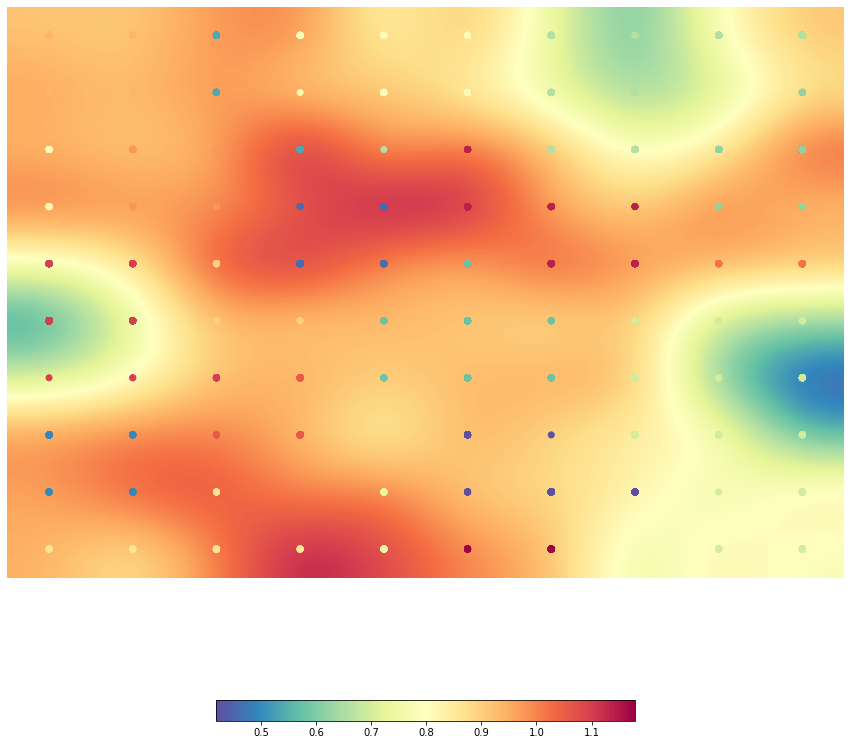

[[13 13  3  9  9  9  6  6  6  6]



 [13 13  3  9  9  9  6  6  6  5]



 [10 14 14  3  6 18  6  6  5  5]



 [10 14 14  1  1 18 18 18  5  5]



 [17 17 12  1  1  4 18 18 15 15]



 [17 17 12 12  4  4  4  7  7  7]



 [17 17 17 16  4  4  4  7  7  7]



 [ 2  2 16 16 16  0  0  7  7  7]



 [ 2  2 11 16  8  0  0  0  7  7]



 [11 11 11 11  8 19 19 19  7  7]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[15.  8. 10. 19.  3. 12.  1.  2. 14. 13. 16.  0.  5. 11. 18.  9.  4. 17.



   6.  7.]



 [ 2.  2.  2.  3.  3.  3.  4.  4.  4.  4.  5.  5.  5.  5.  6.  6.  7.  7.



  10. 13.]]


In [44]:
#k=20
K=20

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [45]:
complete_neuron_movies_report(20, som, ubmus)

Total Number of neurons in cluster 0/20 is 1003







Categories of cluster 0 are 



[('Romance Film', 145), ('World cinema', 103), ('Romantic drama', 99), ('Drama', 97), ('Short Film', 92), ('Musical', 72), ('Bollywood', 43), ('Japanese Movies', 43), ('Silent film', 43), ('Black-and-white', 33), ('Science Fiction', 33), ('Western', 30), ('Action/Adventure', 18), ('Comedy', 14), ('Indie', 9), ('Romantic comedy', 8), ('Art film', 7), ('Chinese Movies', 7), ('Comedy film', 7), ('Comedy-drama', 7), ('Filipino Movies', 6), ('Family Film', 5), ('Film noir', 4), ('Mystery', 4), ('War film', 4), ('Period piece', 3), ('Adventure', 2), ("Children's/Family", 2), ('Christian film', 2), ('Costume drama', 2), ('Crime Fiction', 2), ('Cult', 2), ('Fan film', 2), ('Fantasy', 2), ('Marriage Drama', 2), ('Martial Arts Film', 2), ('Melodrama', 2), ('Monster', 2), ('Political drama', 2), ('Thriller', 2), ('Time travel', 2), ('Action', 1), ('Alien Film', 1), ('Animal Picture', 1), ('Animated cartoon', 1)

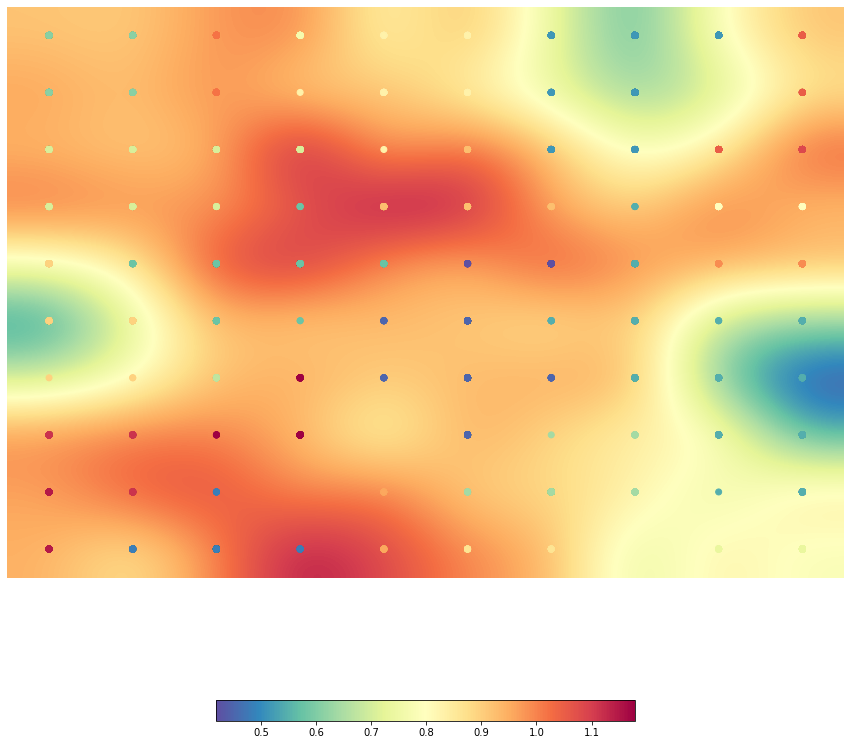

[[ 6  6 19 11 13 13  3  3  3 20]



 [ 6  6 19 13 13 13  3  3  3 20]



 [ 9  9  9  9 13 16  3  3 20 21]



 [ 9  9  9  5 16 16 16  4 12 12]



 [15  5  5  5  5  0  0  4 18 18]



 [15 15  5  5  1  1  4  4  4  4]



 [15 15  8 24  1  1  1  4  4  4]



 [22 22 24 24 24  1  7  7  4  4]



 [23 22  2 24 17  7  7  7  4  4]



 [23  2  2  2 17 14 14  7 10 10]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[21. 11.  8.  0. 19. 18. 17. 14. 23. 10. 12. 20. 22.  6. 16.  2. 15. 24.



   7. 13.  1.  5.  9.  3.  4.]



 [ 1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  4.  4.  4.  5.  5.



   6.  6.  6.  7.  7.  8. 13.]]


In [40]:
#k=25
K=25

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [41]:
complete_neuron_movies_report(25, som, ubmus)

Total Number of neurons in cluster 0/25 is 472







Categories of cluster 0 are 



[('Comedy', 86), ('Drama', 86), ('Comedy-drama', 60), ('Indie', 47), ('Black comedy', 18), ('World cinema', 14), ('Crime Fiction', 12), ('Coming of age', 11), ('Family Drama', 11), ('Period piece', 11), ('Film adaptation', 9), ('Ensemble Film', 8), ('Satire', 8), ('Teen', 7), ('Cult', 4), ('Domestic Comedy', 4), ('Parody', 4), ('Political cinema', 4), ('Road movie', 4), ('Americana', 3), ('Chinese Movies', 3), ('Japanese Movies', 3), ('War film', 3), ('Addiction Drama', 2), ('Buddy film', 2), ('Comedy of manners', 2), ('Documentary', 2), ('Gangster Film', 2), ('Media Satire', 2), ('Political drama', 2), ('Romantic drama', 2), ('Science Fiction', 2), ('Surrealism', 2), ('Tragicomedy', 2), ('Absurdism', 1), ('Adventure', 1), ('Anti-war', 1), ('Art film', 1), ('Biopic [feature]', 1), ('Black-and-white', 1), ('Comedy film', 1), ('Costume drama', 1), ('Crime Comedy', 1), ('Culture & Society', 1), ('Dance',

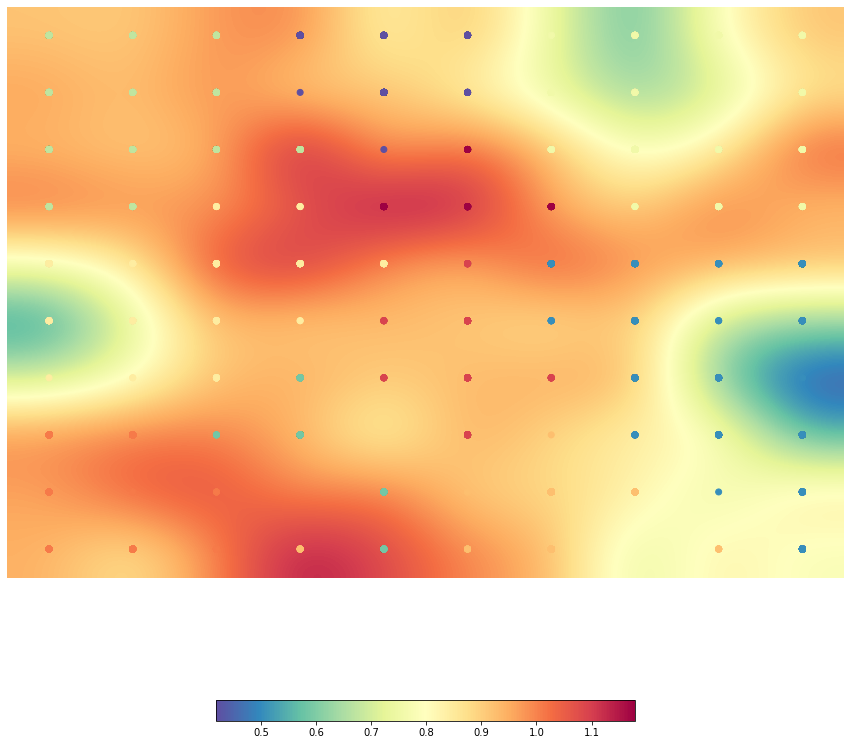

[[3 3 3 0 0 0 4 4 4 4]



 [3 3 3 0 0 0 4 4 4 4]



 [3 3 3 3 0 9 4 4 4 4]



 [3 3 5 5 9 9 9 4 4 4]



 [5 5 5 5 5 8 1 1 1 1]



 [5 5 5 5 8 8 1 1 1 1]



 [5 5 5 2 8 8 8 1 1 1]



 [7 7 2 2 2 8 6 1 1 1]



 [7 7 7 2 2 6 6 6 1 1]



 [7 7 7 6 2 6 6 6 6 1]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[ 9.  0.  2.  8.  7.  6.  3.  5.  4.  1.]



 [ 4.  7.  7.  7.  8.  9. 12. 14. 15. 17.]]


In [42]:
#k=10
K=10

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [43]:
complete_neuron_movies_report(10, som, ubmus)

Total Number of neurons in cluster 0/10 is 1280







Categories of cluster 0 are 



[('Horror', 217), ('Thriller', 92), ('Family Film', 90), ('Adventure', 85), ('Fantasy', 73), ('Animation', 51), ("Children's/Family", 47), ('Comedy', 44), ('Supernatural', 33), ('Psychological thriller', 31), ('World cinema', 28), ("Children's Fantasy", 23), ('Mystery', 23), ("Children's", 22), ('Slasher', 21), ('Drama', 20), ('Science Fiction', 20), ('Indie', 18), ('Musical', 16), ('Creature Film', 15), ('Action', 13), ('Fantasy Adventure', 12), ('Teen', 12), ('Costume drama', 11), ('Japanese Movies', 11), ('Zombie Film', 11), ('Action/Adventure', 10), ('Family-Oriented Adventure', 10), ('Computer Animation', 9), ('Cult', 9), ('Natural horror films', 8), ('Romance Film', 8), ('Animal Picture', 7), ('Crime Fiction', 7), ('Television movie', 7), ('Animated Musical', 6), ('Fantasy Comedy', 6), ('Animated cartoon', 5), ('B-movie', 5), ('Filipino Movies', 5), ('Film adaptation', 5), ('Gothic Film', 5), (

**15x15**

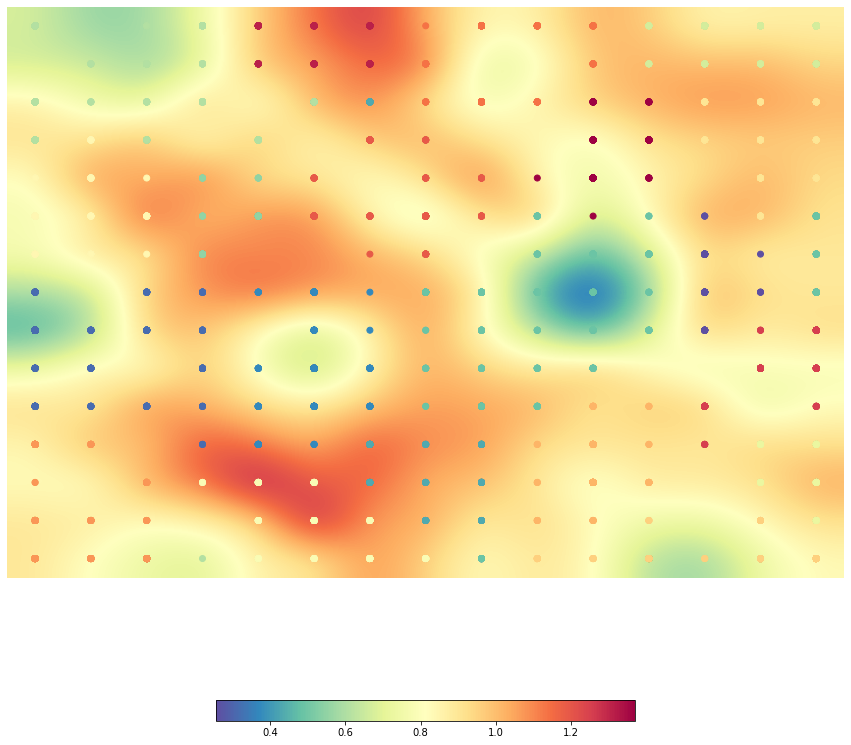

[[ 6  6  6  6 18 18 18 15 15 15 15  7  7  7  7]



 [ 6  6  6  6 18 18 18 15 15 15 15  7  7  7  7]



 [ 6  6  6  6  6  6  3 15 15 15 19 19 11 11 11]



 [ 6 10  6  6  6  6 16 16 15 19 19 19 11 11 11]



 [10 10 10  5  5 16 16 16 16 19 19 19 11 11 11]



 [10 10 10  5  5 16 16 16 16  4 19  4  0 11  4]



 [10 10 10  5  5  2 16 16  4  4  4  4  0  0  4]



 [ 1  1  1  1  2  2  2  4  4  4  4  4  0  0  4]



 [ 1  1  1  1  2  2  2  4  4  4  4  4  0 17 17]



 [ 1  1  1  1  2  2  2  4  4  4  4  4 17 17 17]



 [ 1  1  1  1  2  2  2  4  4  4 13 13 17 17 17]



 [14 14  1  1  2  2  3  3  3 13 13 13 17  8  8]



 [14 14 14  9  9  9  3  3  3 13 13 13 12  8  8]



 [14 14 14  6  9  9  9  3  3 13 13 12 12 12  8]



 [14 14 14  6  9  9  9  9  4 12 12 12 12 12 12]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[ 8.  0. 18.  5.  7. 17. 19.  3. 10. 11. 12. 13.  9. 14. 15. 16.  2.  1.



   6.  4.]



 [ 5.  6.  6.  6.  8.  9.  9.  9. 10. 10. 10. 10. 

In [46]:
#k=20
K=20

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_15.cluster(algorithm=algorithm)
som_15.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_15.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_15.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [47]:
complete_neuron_movies_report(20, som_15, ubmus_15)

Total Number of neurons in cluster 0/20 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/20 is 3283







Categories of cluster 1 are 



[('Thriller', 295), ('Comedy', 242), ('Horror', 222), ('Action', 186), ('Drama', 186), ('Romance Film', 176), ('Crime Thriller', 151), ('Crime Fiction', 118), ('Black-and-white', 103), ('Romantic comedy', 103), ('World cinema', 92), ('Action/Adventure', 80), ('Mystery', 80), ('Indie', 74), ('Psychological thriller', 70), ('Slasher', 57), ('Adventure', 47), ('Suspense', 43), ('Cult', 38), ('B-movie', 34), ('Family Film', 34), ('Teen', 33), ('Fantasy', 29), ('Musical', 26), ('Film adaptation', 24), ('Martial Arts Film', 24), ('Film noir', 23), ('Supernatural', 23), ('Science Fiction', 22), ('Creature Film', 20), ('Romantic drama', 20), ('Period piece', 19), ('Action Thrillers', 18), ('Japanese Movies', 16), ('Slapstick', 16), ('Zombie Film', 16), ('Chinese Movies', 15), ('Comedy-drama', 15), ('Satire', 15), ('

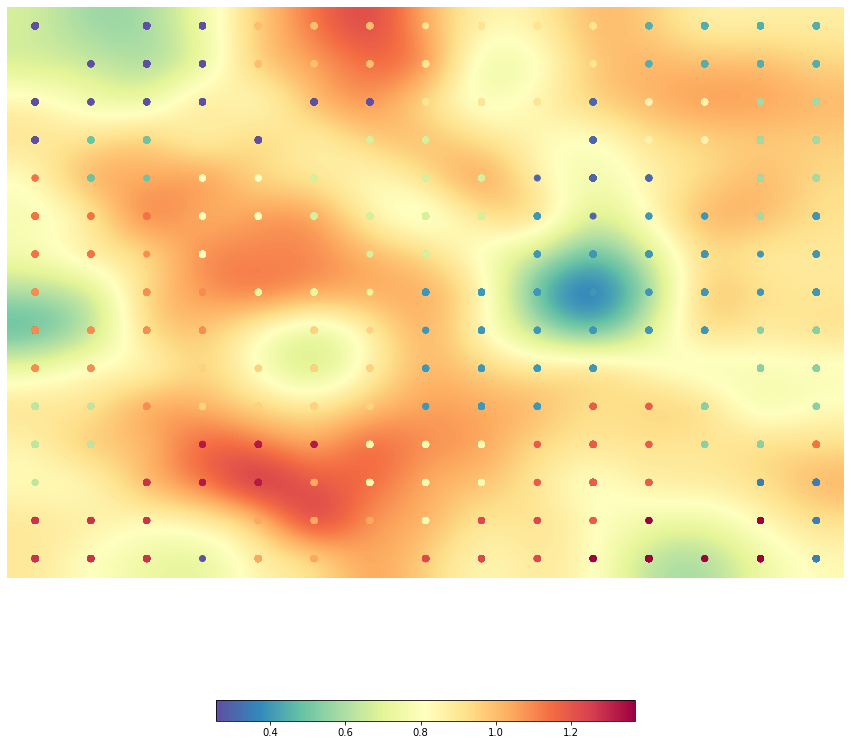

[[ 0  0  0  0 16 16 16 14 14 14 14  4  4  4  4]



 [ 0  0  0  0 16 16 16 14 14 14 14  4  4  4  4]



 [ 0  0  0  0  0  0  0 14 14 14  1 13 13  7  7]



 [ 0  5  5  0  0  0  9  9 14  1  1 13 13  7  7]



 [19  5  5 12 12  9  9  9  9  1  1  1 13  7  7]



 [19 19 19 12 12  9  9  9  9  3  1  3  3  7  3]



 [19 19 18 12 12 10  9  9  3  3  3  3  3  3  3]



 [18 18 18 18 10 10 10  3  3  3  3  3  3  3  3]



 [18 18 18 18 15 15 15  3  3  3  3  3  3  6  6]



 [18 18 18 15 15 15 15  3  3  3  3  3  6  6  6]



 [ 8  8 18 15 15 15 15  3  3  3 20 20  6  6  6]



 [ 8  8  8 23 23 23 11 11 11 20 20 20  6  6 19]



 [ 8  8 22 23 23 17 11 11 11 20 20 20 24  2  2]



 [22 22 22  0 17 17 17 11 21 21 20 24 24 24  2]



 [22 22 22  0 17 17 17 21 21 21 24 24 24 24  2]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[ 2.  5. 10. 21. 23. 13. 12. 16.  1. 22. 19.  7.  8. 17. 11. 24.  4. 20.



   6. 15. 14.  9. 18.  0.  3.]



 [ 4.  4.  4.  5.  5.  5.  6. 

In [48]:
#k=25
K=25

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_15.cluster(algorithm=algorithm)
som_15.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_15.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_15.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [49]:
complete_neuron_movies_report(25, som_15, ubmus_15)

Total Number of neurons in cluster 0/25 is 3474







Categories of cluster 0 are 



[('Drama', 629), ('Thriller', 197), ('Comedy', 186), ('Action', 177), ('Action/Adventure', 170), ('Romance Film', 122), ('Horror', 106), ('World cinema', 105), ('Crime Fiction', 102), ('Romantic comedy', 94), ('Short Film', 94), ('Comedy film', 93), ('Science Fiction', 82), ('Family Film', 63), ('Mystery', 57), ('Romantic drama', 56), ('Indie', 55), ('Fantasy', 53), ('Chinese Movies', 49), ('Martial Arts Film', 43), ('Adventure', 42), ('Family Drama', 41), ('Comedy-drama', 37), ('Japanese Movies', 37), ('Musical', 30), ('Psychological thriller', 30), ('Supernatural', 27), ('Crime Thriller', 26), ('Black comedy', 23), ('Coming of age', 22), ('Slasher', 21), ('Western', 21), ('Film adaptation', 19), ('Teen', 19), ('Action Thrillers', 18), ('Buddy film', 16), ('Animation', 15), ('Cult', 14), ('Sports', 14), ('Melodrama', 13), ('Parody', 13), ('Action Comedy', 12), ('Anime', 12), ('War film', 12), ('Come

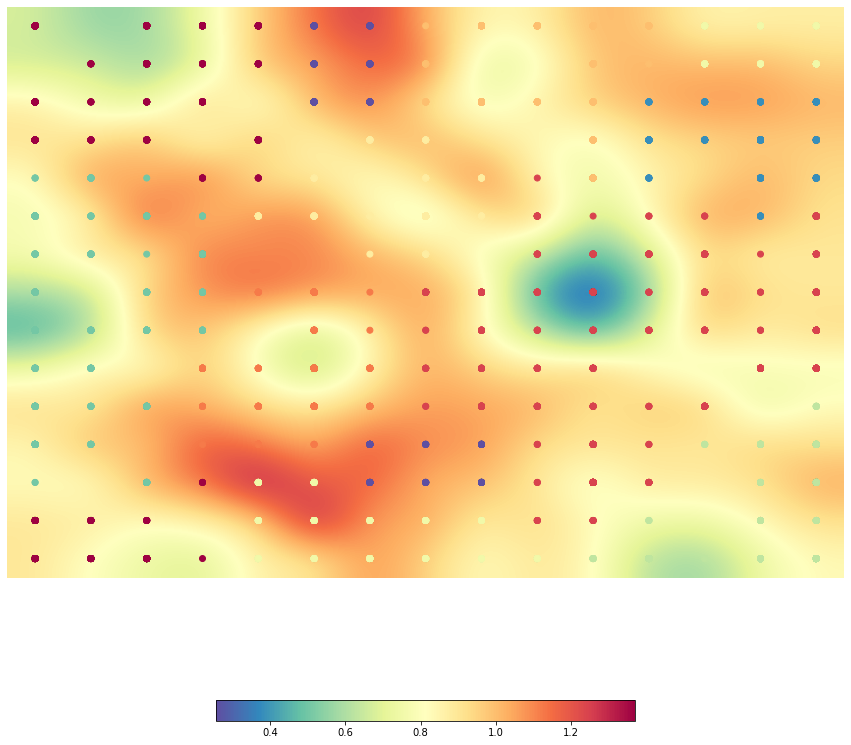

[[9 9 9 9 9 0 0 6 6 6 6 6 4 4 4]



 [9 9 9 9 9 0 0 6 6 6 6 6 4 4 4]



 [9 9 9 9 9 0 0 6 6 6 6 1 1 1 1]



 [9 9 9 9 9 9 5 5 6 6 6 1 1 1 1]



 [2 2 2 9 9 5 5 5 5 8 6 1 1 1 1]



 [2 2 2 2 5 5 5 5 5 8 8 8 8 1 8]



 [2 2 2 2 2 7 5 5 8 8 8 8 8 8 8]



 [2 2 2 2 7 7 7 8 8 8 8 8 8 8 8]



 [2 2 2 2 7 7 7 8 8 8 8 8 8 8 8]



 [2 2 2 7 7 7 7 8 8 8 8 8 8 8 8]



 [2 2 2 7 7 7 7 8 8 8 8 8 8 8 3]



 [2 2 2 7 7 7 0 0 0 8 8 8 3 3 3]



 [2 2 2 9 4 4 0 0 0 8 8 8 3 3 3]



 [9 9 9 9 4 4 4 4 4 8 8 3 3 3 3]



 [9 9 9 9 4 4 4 4 4 4 3 3 3 3 3]]







Cluster sorted by increasing number of neurons:



Cluster index



Number of neurons



[[ 0.  1.  5.  3.  6.  7.  4.  2.  9.  8.]



 [12. 13. 13. 16. 18. 18. 19. 32. 32. 52.]]


In [50]:
#k=10
K=10

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_15.cluster(algorithm=algorithm)
som_15.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_15.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_15.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [51]:
complete_neuron_movies_report(10, som_15, ubmus_15)

Total Number of neurons in cluster 0/10 is 1625







Categories of cluster 0 are 



[('Drama', 705), ('Romance Film', 166), ('Black-and-white', 129), ('Comedy film', 124), ('Silent film', 61), ('Indie', 41), ('Melodrama', 23), ('Chinese Movies', 18), ('Crime Fiction', 18), ('War film', 15), ('Action', 13), ('Science Fiction', 13), ('Fantasy', 12), ('Film noir', 12), ('Mystery', 12), ('Western', 12), ('Japanese Movies', 11), ('Musical', 11), ('Family Film', 10), ('Romantic drama', 9), ('Action/Adventure', 8), ('Pre-Code', 8), ('Comedy-drama', 7), ('Marriage Drama', 7), ('Romantic comedy', 7), ('Short Film', 7), ('Biographical film', 6), ('Film adaptation', 6), ('Horror', 6), ('Music', 6), ('Family Drama', 5), ('Adventure', 4), ('Comedy', 4), ('Disaster', 4), ('Historical drama', 4), ('Biopic [feature]', 3), ('Black comedy', 3), ('Coming of age', 3), ('Courtroom Drama', 3), ('Crime Drama', 3), ('Documentary', 3), ('Gangster Film', 3), ('Historical fiction', 3), ('History', 3), ('Polit

**20x20**

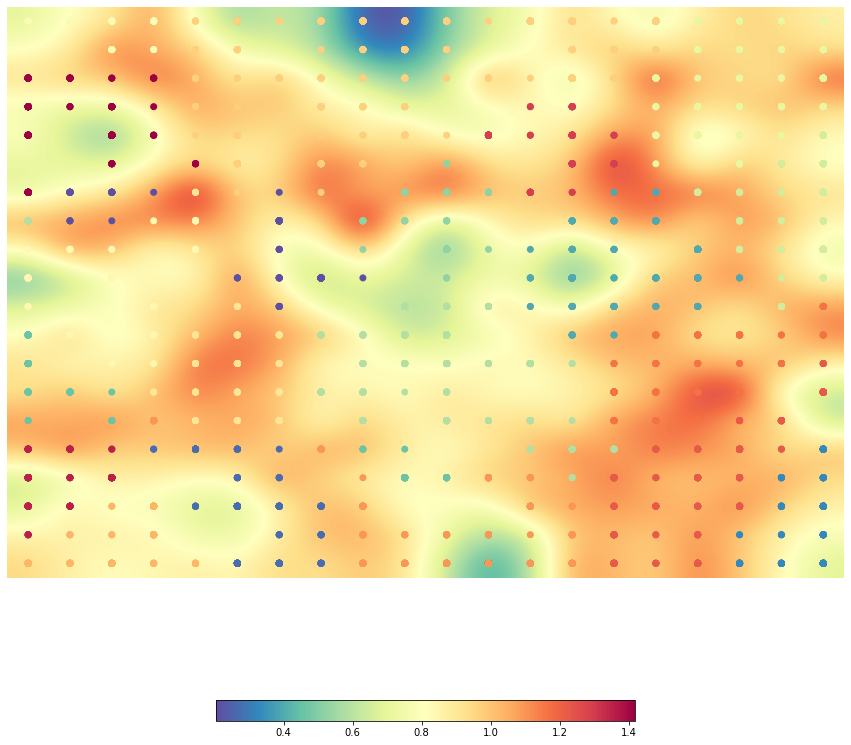

[[ 9  9  9  9 12 12 12 12 12 12 12 12 12 12 12 12  8  8  8  8]



 [19  9  9  9 12 12 12 12 12 12 12 12 12 12 12 12  8  8  8  8]



 [19 19 19 19 12 12 12 12 12 12 12 12 12 12 12  8  8  8  8  8]



 [19 19 19 19 12 12 12 12 12 12 12 17 17 17 17  8  8  8  8  8]



 [19 19 19 19 12 12 12 12 12 12 12 17 17 17 17  8  8  8  8  7]



 [19 19 19 19 19 12 12 12 12 12  5 17 17 17 17  8  8  8  7  7]



 [19  0  0  0 11 12  0 12 12  5  5  5 17 17  3  3  7  7  7  7]



 [ 6  0  0 10 10  0  0  0  5  5  5  5  6  3  3  3  3  7  7  7]



 [10 10 10 10 10 10  0  0  5  5  5  5  3  3  3  3  3  7  7  7]



 [10 10 10 10 10  0  0  0  0  6  5  5  3  3  3  3  3  3  7  7]



 [10 10 10 10 10 11  0  0  6  6  6  6  3  3  3  3  3 15  7 15]



 [ 4 10 10 10 11 11 11  6  6  6  6  6  6  3  3 15 15 15 15 15]



 [ 4  4 10 10 11 11 11  6  6  6  6  6  6  6 15 15 15 15 15 16]



 [ 4  4  4 11 11 11 11  6  6  6  6  6  6 15 15 15 15 15 16 16]



 [ 4  4  4 14 11 11 11  6  6  6  6  6  6  6 15 15 15 16 16 16]



 [18 18 18

In [52]:
#k=20
K=20

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_20.cluster(algorithm=algorithm)
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_20.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [53]:
complete_neuron_movies_report(20, som_20, ubmus_20)

Total Number of neurons in cluster 0/20 is 1189







Categories of cluster 0 are 



[('Romance Film', 194), ('Drama', 189), ('Romantic drama', 152), ('Romantic comedy', 88), ('Comedy', 86), ('Indie', 41), ('Film adaptation', 35), ('Period piece', 34), ('Comedy-drama', 30), ('World cinema', 24), ('Black-and-white', 17), ('Musical', 14), ('Action/Adventure', 13), ('Family Drama', 12), ('Fantasy', 11), ('Coming of age', 10), ('Crime Fiction', 10), ('Comedy of manners', 9), ('Thriller', 9), ('Action', 8), ('Costume drama', 8), ('Adventure', 7), ('Mystery', 7), ('Teen', 7), ('War film', 7), ('Biography', 6), ('Biopic [feature]', 6), ('Melodrama', 6), ('Biographical film', 5), ('Black comedy', 5), ('Chinese Movies', 5), ('Ensemble Film', 5), ('Epic', 5), ('Television movie', 5), ('Western', 5), ('Courtroom Drama', 4), ('Marriage Drama', 4), ('Political drama', 4), ('Road movie', 4), ('Sex comedy', 4), ('Sports', 4), ('Buddy film', 3), ('Christian film', 3), ('Dance', 3), ('Domestic Comedy

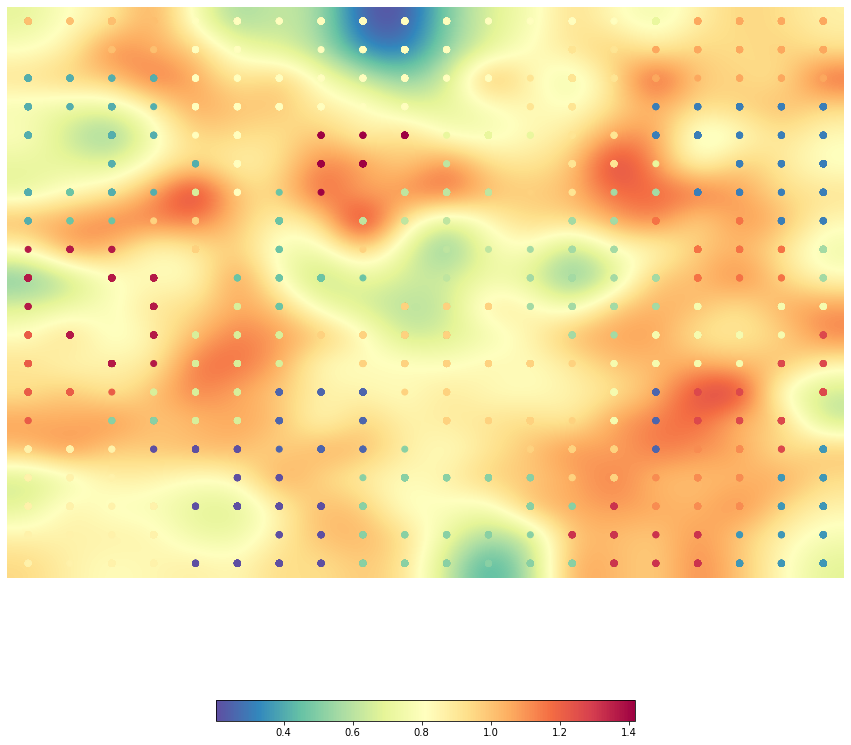

[[16 16 16 16 12 12 12 12 12 12 12 12 12 12 12 10 17 17 17 17]



 [16 16 16 16 12 12 12 12 12 12 12 12 12 14 14 17 17 17 17 17]



 [ 4  4  4  4 12 12 12 12 12 12 12 12 14 14 14 17 17 17 17 17]



 [ 4  4  4  4 12 12 12 12 12 12 10 10 14 14 14  2  2  2  2  2]



 [ 4  4  4  4 12 12 12 24 24 24 10 10 10 14 14  2  2  2  2  2]



 [ 4  4  4  4  4 12 12 24 24 24  8 10 14 14 14 10  2  2  2  2]



 [ 4  5  4  4  9 12  5 24 24  8  8  8 15 14  7  7  2  2  2  2]



 [ 4  5  5 15 15  5  5  5  8  8  8  8 15  7  7 19 19 19  2  2]



 [23 23 23 23 15 15  5  5 15  8  8  8  7  7  7 19 19 19 19  7]



 [23 23 23 23 23  5  5  5  5 15  8 15  7  7  7  7 19 19 19  7]



 [23 23 23 23 23  9  5  5 15 15 15 15  7  7  7  7 11 11 11 11]



 [20 23 23 23  9  9  9 15 15 15 15 15 15  7  7 11 11 11 11 21]



 [20 20 23 23  9  9  9  1 15 15 15 15 15 15 11 11 11 11 21 21]



 [20 20 20  9  9  9  1  1  1 15 15 15 15 15 11  1 21 21 21 21]



 [20 20  6  6  9  9  1  1  1 15 15 15 15 15 11  1 21 21 21 21]



 [13 13 13

In [54]:
#k=25
K=25

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_20.cluster(algorithm=algorithm)
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_20.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [55]:
complete_neuron_movies_report(25, som_20, ubmus_20)

Total Number of neurons in cluster 0/25 is 533







Categories of cluster 0 are 



[('Drama', 142), ('World cinema', 137), ('Bollywood', 29), ('Musical', 25), ('Crime Fiction', 21), ('Art film', 17), ('Romance Film', 13), ('War film', 10), ('Indie', 9), ('Action/Adventure', 7), ('Political drama', 7), ('Chinese Movies', 6), ('Family Drama', 6), ('Black-and-white', 5), ('Japanese Movies', 5), ('Action', 4), ('Biography', 4), ('Childhood Drama', 4), ('Christian film', 4), ('Biographical film', 3), ('Epic', 3), ('Family Film', 3), ('Filipino Movies', 3), ('Melodrama', 3), ('Thriller', 3), ('Adventure', 2), ('Comedy', 2), ('Comedy film', 2), ('Coming of age', 2), ('Ensemble Film', 2), ('Fantasy', 2), ('Historical Epic', 2), ('Horror', 2), ('Music', 2), ('Satire', 2), ('Sports', 2), ('Television movie', 2), ('Animation', 1), ('Avant-garde', 1), ('Biopic [feature]', 1), ('Boxing', 1), ('Buddy film', 1), ('Comedy-drama', 1), ('Concert film', 1), ('Creature Film', 1), ('Crime Thriller', 1),

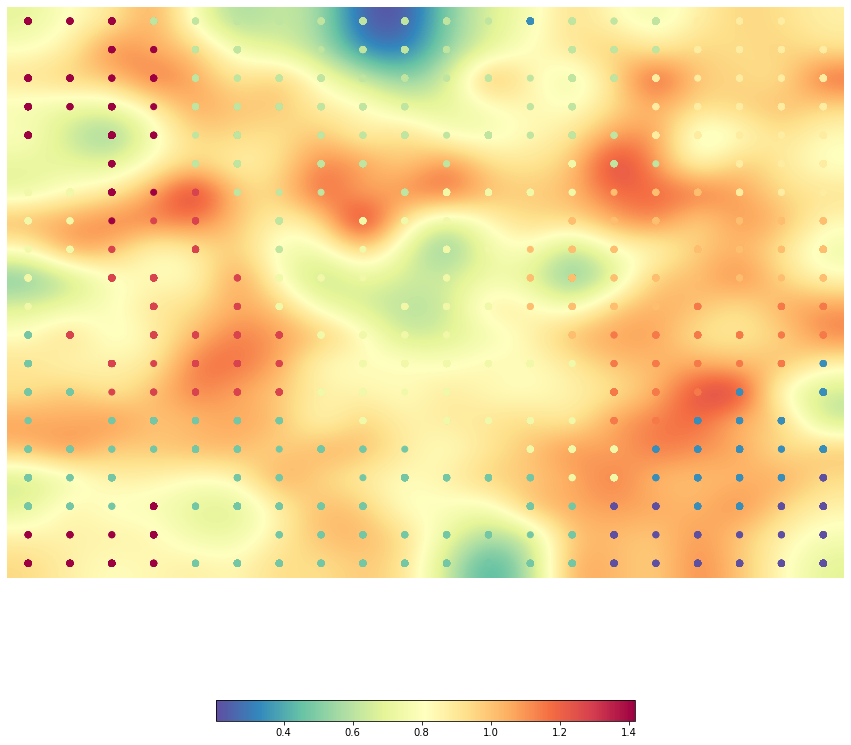

[[9 9 9 3 3 3 3 3 3 3 3 3 1 3 3 3 5 5 5 5]



 [9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5]



 [9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5]



 [9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5]



 [9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5]



 [9 9 9 9 3 3 3 3 3 3 3 3 4 4 3 3 5 5 5 5]



 [4 4 9 9 8 3 3 3 3 3 4 4 4 4 6 6 6 5 5 5]



 [4 4 9 8 8 3 3 3 4 4 4 4 4 6 6 6 6 6 6 6]



 [4 4 8 8 8 8 3 4 4 4 4 4 6 6 6 6 6 6 6 6]



 [4 4 8 8 8 8 4 4 4 4 4 4 6 6 6 6 6 6 6 6]



 [4 8 8 8 8 8 4 4 4 4 4 4 6 6 6 6 7 7 7 7]



 [2 8 8 8 8 8 8 4 4 4 4 4 4 6 7 7 7 7 7 7]



 [2 8 8 8 8 8 8 4 4 4 4 4 4 4 7 7 7 7 7 1]



 [2 2 8 8 8 8 8 4 4 4 4 4 4 7 7 7 7 1 1 1]



 [2 2 2 2 2 2 2 2 4 4 4 4 4 4 7 7 1 1 1 1]



 [2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 1 1 1 1 1]



 [2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 1 1 1 1 0]



 [2 2 2 9 2 2 2 2 2 2 2 2 2 2 0 0 1 1 0 0]



 [9 9 9 9 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]



 [9 9 9 9 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]]







Cluster sorted by increasing number of neurons:



Cluster index



Number 

In [56]:
#k=10
K=10

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_20.cluster(algorithm=algorithm)
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_20.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [57]:
complete_neuron_movies_report(10, som_20, ubmus_20)

Total Number of neurons in cluster 0/10 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/10 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/10 is 3599







Categories of cluster 2 are 



[('Comedy', 473), ('Drama', 472), ('Romance Film', 356), ('World cinema', 193), ('Romantic comedy', 119), ('Indie', 97), ('Short Film', 96), ('Action', 83), ('Family Film', 74), ('Comedy-drama', 71), ('Musical', 71), ('Black-and-white', 69), ('Period piece', 68), ('Parody', 59), ('Adventure', 58), ('Action/Adventure', 56), ('Animation', 54), ('Thriller', 49), ('Crime Fiction', 46), ('Bollywood', 39), ('Romantic drama', 36), ('Science Fiction', 34), ('Fantasy', 33), ('War film', 33), ('Black comedy', 30), ('Coming of age', 28), ('Mystery', 26), ('Film adaptation', 25), ('Slapstick', 25), ('Cult', 23), ('Teen', 23), ('Biography', 22), ('Satire', 22), ('Art film', 21), ('Family Drama', 21), ('Comedy film', 20), ('Biogr

**25x25**

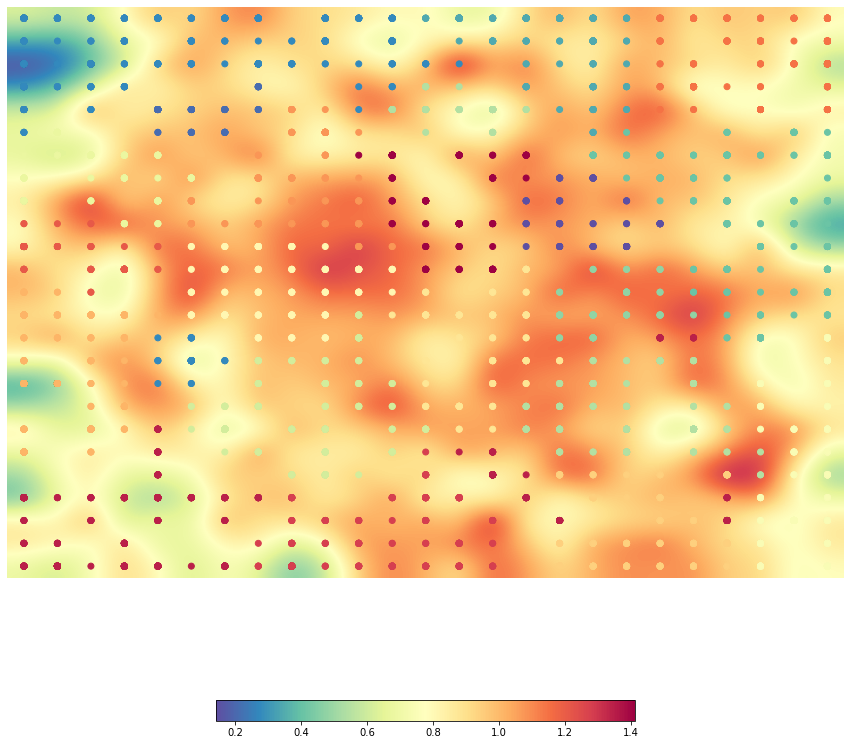

[[ 2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3 15 15 15 15 15



  15]



 [ 2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3 15 15 15 15 15



  15]



 [ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3 15 15 15 15 15



  15]



 [ 2  2  2  2  2  1  1  1  2  2  2  2  6  6  6  3  3  3  3 15 15 15 15 15



  15]



 [ 2  2  2  2  1  1  1  1 14 14  2  6  6  6  6  6  3  3  3 15 15 15 15 15



  15]



 [ 2  8  8  8  1  1  1  1 14 14 14 19  6  6  6  6  3  3  4  4  4  4  4  4



   4]



 [ 8  8  8  8  8  8  1 14 14 14 19 19 19 19 19 19  0  4  4  4  4  4  4  4



   4]



 [ 8  8  8  8  8  8 14 14 14 14 14 19 19 19 19 19  0  0  4  4  4  4  4  4



   4]



 [ 8  8  8  8  8 14 14 14 14 14 14 19 19 19 19  0  0  0  0  4  4  4  4  4



   4]



 [16 16 16  8  8 14 14 14 14 14 14 19 19 19 19  0  0  0  0  0  4  4  4  4



   4]



 [16 16 16 16 16 10 10 10 10 10 14 14 19 19 19  0  0  0  0  0  4  4  4  4



   4]



 [16 16 16 16 16 10 10 10 10 10 10 10 19 19 19 11 11  

In [58]:
#k=20
K=20

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_25.cluster(algorithm=algorithm)
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_25.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_25.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [59]:
complete_neuron_movies_report(20, som_25, ubmus_25)

Total Number of neurons in cluster 0/20 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/20 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/20 is 4128







Categories of cluster 2 are 



[('Comedy', 610), ('Drama', 424), ('Action', 216), ('Action/Adventure', 216), ('Romance Film', 189), ('World cinema', 133), ('Crime Fiction', 131), ('Comedy film', 111), ('Adventure', 99), ('Short Film', 96), ('Indie', 92), ('Thriller', 90), ('Family Film', 88), ('Fantasy', 87), ('Black-and-white', 74), ('Musical', 71), ('Comedy-drama', 62), ('Black comedy', 54), ('Animation', 48), ('Chinese Movies', 43), ('Martial Arts Film', 41), ("Children's/Family", 39), ('War film', 37), ('Romantic comedy', 35), ('Horror', 32), ('Buddy film', 29), ('Japanese Movies', 29), ('Western', 28), ('Science Fiction', 27), ('Crime Thriller', 26), ("Children's", 25), ('Satire', 25), ('Sports', 25), ('Mystery', 24), ('Film adaptation', 23)

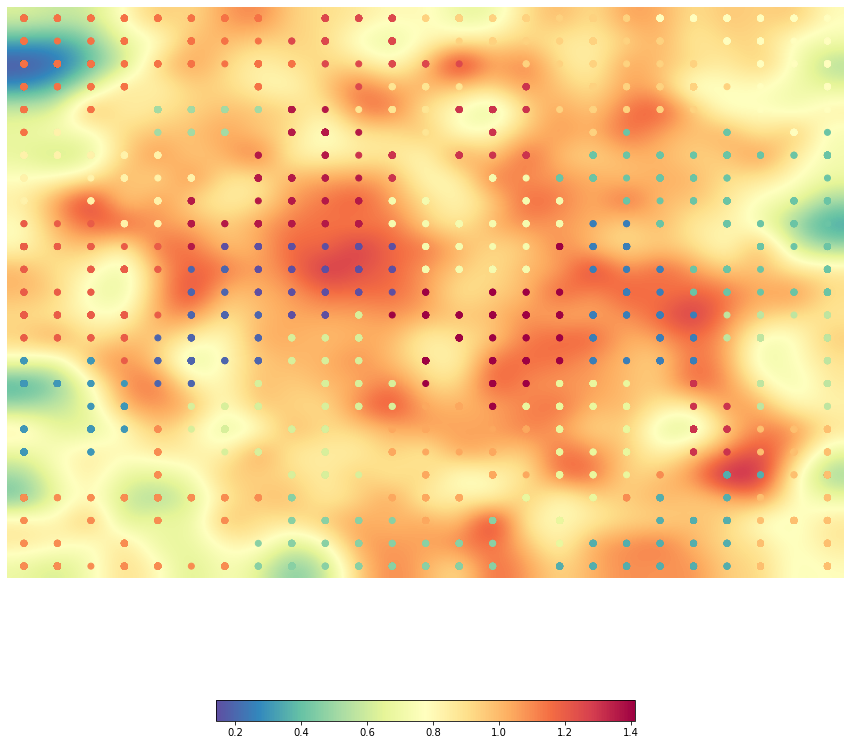

[[19 19 19 19 19 19 19 19 21 21 21 21 15 15 15 15 15 15 15 12 12 12 12 12



  12]



 [19 19 19 19 19 19 19 19 21 21 21 21 21 15 15 15 15 15 15 15 12 12 12 12



  12]



 [19 19 19 19 19 19 19 19 19 21 21 21 21 21 15 15 15 15 15 15 15 12 12 12



  12]



 [19 19 19 19  7  7  7 19 19 21 21 14 14 14 22 22 15 15 15 15 15 15 12 12



  12]



 [19 19 19  7  7  7  7  7 23 23 14 14 14 22 22 22 15 15 15 15 15 12 12 12



  12]



 [19 13 13 13  7  7  7 19 23 23 23 22 14 22 22 22 15 15  5  5  5  5  5 12



   5]



 [13 13 13 13 13 13 19 23 23 23 22 22 22 22 22 22  5  5  5  5  5  5  5  5



   5]



 [13 13 13 13 13 13 23 23 23 23 23 22 22 22 11 11  5  5  5  5  5  5  5  5



   5]



 [13 13 13 13 13 23 23 23 23 23 23 11 11 11 11 11 11  5  5  5  5  5  5  5



   5]



 [20 20 20 13 13 23 23 23 23 23 23 11 11 11 11 11 11  2  2  5  5  5  5  5



   5]



 [20 20 20 20 20 23  0  0  0  0  0  0 11 11 11 11 24  2  2  2  5  5  5  5



   5]



 [20 20 20 20 20  1  1  0  0  0  0  0 11 11 11 11 24  

In [60]:
#k=25
K=25

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_25.cluster(algorithm=algorithm)
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_25.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_25.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [61]:
complete_neuron_movies_report(25, som_25, ubmus_25)

Total Number of neurons in cluster 0/25 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/25 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/25 is 0







Categories of cluster 2 are 



[]







Total Number of neurons in cluster 3/25 is 3648







Categories of cluster 3 are 



[('Drama', 752), ('Romance Film', 240), ('Romantic drama', 194), ('Comedy', 157), ('Horror', 144), ('Mystery', 119), ('Thriller', 112), ('World cinema', 108), ('Musical', 92), ('Family Film', 80), ('Crime Fiction', 75), ('Black-and-white', 67), ('Bollywood', 54), ('Indie', 52), ('Japanese Movies', 48), ('Adventure', 47), ('Film adaptation', 44), ('Parody', 44), ('Silent film', 41), ('Chinese Movies', 40), ('Western', 40), ('Period piece', 37), ("Children's/Family", 35), ('Action/Adventure', 33), ('Science Fiction', 33), ('Fantasy', 32), ('Television movie', 29), ('Comedy-drama', 25), ('Slapstick', 25), ('Biographical film',

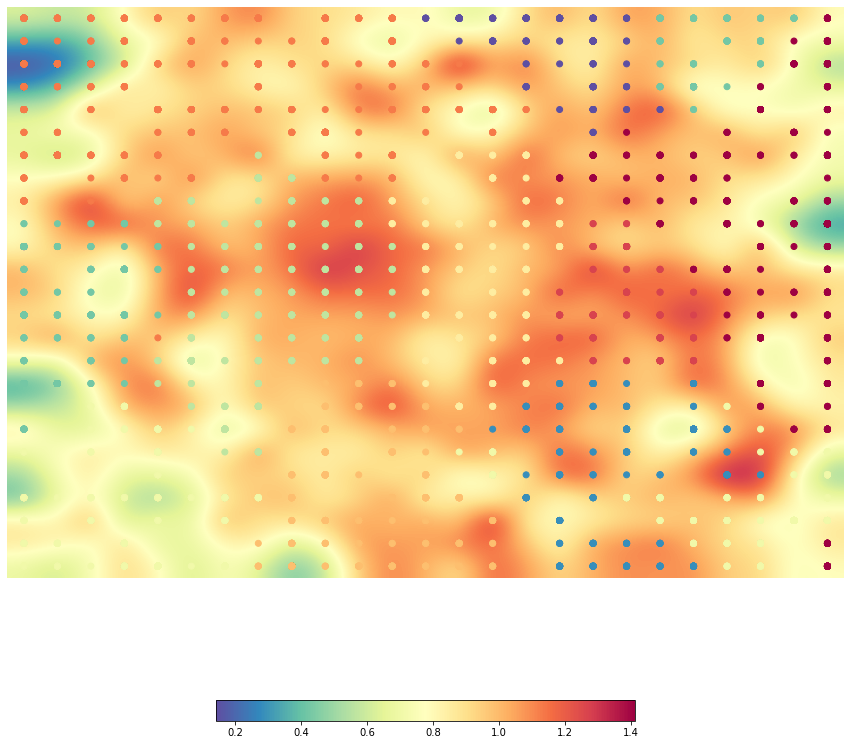

[[7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 2 2 2 2 2 9]



 [7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 2 2 2 2 9 9]



 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 2 2 2 2 9 9]



 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 2 2 2 9 9 9]



 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 2 9 9 9 9]



 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 9 9 9 9 9 9 9]



 [7 7 7 7 7 7 7 3 3 7 7 7 7 5 5 5 9 9 9 9 9 9 9 9 9]



 [7 7 7 7 7 7 3 3 3 7 7 7 5 5 5 5 9 9 9 9 9 9 9 9 9]



 [7 7 7 7 3 3 3 3 3 3 3 5 5 5 5 5 5 9 9 9 9 9 9 9 9]



 [2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 5 5 8 8 9 9 9 9 9 9]



 [2 2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 5 8 8 8 9 9 9 9 9]



 [2 2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 5 8 8 8 9 9 9 9 9]



 [2 2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 8 8 8 8 8 9 9 9 9]



 [2 2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 8 8 8 8 8 9 9 9 9]



 [2 2 2 2 7 3 3 3 3 3 3 3 5 5 5 5 8 8 8 8 8 9 9 9 9]



 [2 2 2 2 3 3 3 3 3 3 3 5 5 5 5 5 5 8 8 8 8 9 9 9 9]



 [2 2 2 2 3 3 3 3 3 6 6 6 5 5 5 5 1 1 1 8 1 9 9 9 9]



 [2 2 4 4 4 3 3 3 3 6 6 6 6 5 5 1 1 1 1 1 1 4 9 

In [62]:
#k=10
K=10

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_25.cluster(algorithm=algorithm)
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_25.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_25.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [63]:
complete_neuron_movies_report(10, som_25, ubmus_25)

Total Number of neurons in cluster 0/10 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/10 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/10 is 5330







Categories of cluster 2 are 



[('Drama', 404), ('Comedy', 302), ('Thriller', 234), ('Family Film', 227), ('Horror', 227), ('Short Film', 209), ('Black-and-white', 202), ('Romance Film', 198), ('Animation', 179), ('Action', 157), ('Adventure', 153), ('Action/Adventure', 140), ('Crime Fiction', 133), ('Indie', 132), ('Documentary', 130), ('Mystery', 119), ('Romantic drama', 115), ('Crime Thriller', 107), ('World cinema', 80), ('Musical', 74), ('Comedy film', 66), ('Film adaptation', 62), ('Fantasy', 61), ('Silent film', 60), ('Science Fiction', 59), ('Slasher', 55), ('Period piece', 53), ('Parody', 51), ('Cult', 47), ('Family Drama', 41), ('Psychological thriller', 41), ('Teen', 35), ('B-movie', 34), ('War film', 32), ("Children's/Family", 31), ('

**30x30**

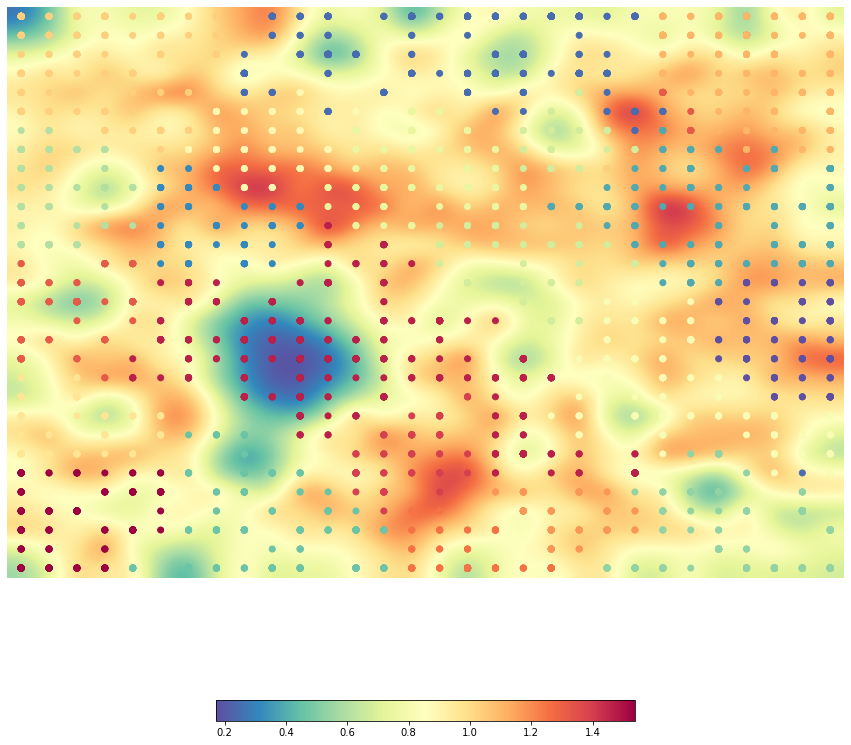

[[12 12 12 12 12 12 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 13



  13 13 13 13 13 13]



 [12 12 12 12 12 12 12 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1 13 13



  13 13 13 13 13 13]



 [12 12 12 12 12 12 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1 13 13



  13 13 13 13 13 13]



 [12 12 12 12 12 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 13



  13 13 13 13 13 13]



 [12 12 12 12 12 12 12 10  1  1 10  1  1  1  1  1  1  1  1  1  7  1  1 16



  13 13 13 13 13 13]



 [12 12 12 12 12 12 12 10 10 10 10  1 10  1  8  8  1  1  1  7  7  1  1  1



  16 13 13 13 13 13]



 [ 6  6  6 12 12 12 12 10 10 10 10 10  8  8  8  8  8  8  7  7  7  7  1  3



  16 13 13 13 13 13]



 [ 6  6  6  6  6 12 10 10 10 10 10 10  8  8  8  8  8  8  7  7  7  7  7  3



   3  3 13  3 13 13]



 [ 6  6  6  6  6  2  2 10 10 10 10 10  8  8  8  8  8  8  7  7  7 12  3  3



   3  3  3  3  3  3]



 [ 6  6  6  6  6  2  2  2 10 10 10  8  8  8  8  8  8  8  8  7  3  3  3  3



   3  3  3  3 

In [16]:

K=20

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_30.cluster(algorithm=algorithm)
som_30.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_30.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_30.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [21]:
complete_neuron_movies_report(20, som_30, ubmus_30)

Total Number of neurons in cluster 0/20 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/20 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/20 is 0







Categories of cluster 2 are 



[]







Total Number of neurons in cluster 3/20 is 0







Categories of cluster 3 are 



[]







Total Number of neurons in cluster 4/20 is 0







Categories of cluster 4 are 



[]







Total Number of neurons in cluster 5/20 is 0







Categories of cluster 5 are 



[]







Total Number of neurons in cluster 6/20 is 3372







Categories of cluster 6 are 



[('Romance Film', 278), ('Thriller', 251), ('Drama', 230), ('Horror', 210), ('Comedy', 164), ('World cinema', 144), ('Action', 117), ('Action/Adventure', 111), ('Romantic comedy', 110), ('Crime Thriller', 97), ('Musical', 88), ('Romantic drama', 88), ('Crime Fiction', 80), ('Adventure', 70), ('Black-and-white', 68), ('Mystery', 62), ('Indie', 60),

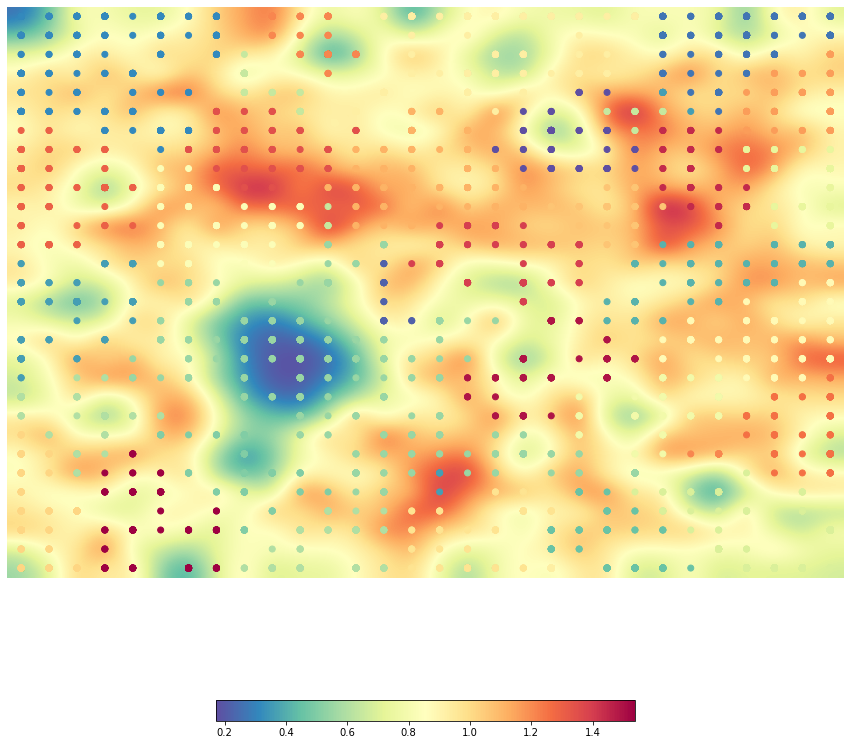

[[ 3  3  3  3  3  3  3  3 22 22 22 22 22 16 16 16 16 16 16 16 16 16 16  2



   2  2  2  2  2  2]



 [ 3  3  3  3  3  3  3  3  3 22 22 22 22 16 16 16 16 16 16 16 16 16  2  2



   2  2  2  2  2  2]



 [ 3  3  3  3  3  3  3  3 10 22 22 22 22 22 16 16 16 16 16 16 16 16  2  2



   2  2  2  2 21 21]



 [ 3  3  3  3  3  3  3 10 10 10 22 22 22 16 16 16 16 16 16 16 16 16 16  2



   2  2  2 21 21 21]



 [ 3  3  3  3  3  3  3 10 10 10 10 16 16 16 16 16 16 16 16  0  0  0 10  4



   2  2 21 21 21 21]



 [ 3  3  3  3  3  3  3 25 25 25 10 16 16 16 20 20 16 16  0  0  0 10 10 10



   4  2 21 21 21 21]



 [24 24 24  3  3  3  3 25 25 25 25 25 25 20 20 20 20 20  0  0  0  0 10 27



  27 27 21 21 21 21]



 [24 24 24 24 24  3 25 25 25 25 25 25 20 20 20 20 20  0  0  0  0  0  0 27



  27 27 12 12 12 12]



 [24 24 24 24 24 14 14 25 25 25 25 25 20 20 20 20 20 20  0  0  0  0  0 27



  27 27 12 12 12 12]



 [24 24 24 24 24 14 14 14 25 25 25 20 20 20 20 20 20 20 20  0 19 19 19 27



  27 27 27 12 

In [22]:

K=30

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_30.cluster(algorithm=algorithm)
som_30.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_30.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_30.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [23]:
complete_neuron_movies_report(30, som_30, ubmus_30)

Total Number of neurons in cluster 0/30 is 0







Categories of cluster 0 are 



[]







Total Number of neurons in cluster 1/30 is 0







Categories of cluster 1 are 



[]







Total Number of neurons in cluster 2/30 is 0







Categories of cluster 2 are 



[]







Total Number of neurons in cluster 3/30 is 4748







Categories of cluster 3 are 



[('Drama', 851), ('Comedy', 439), ('Action', 221), ('Action/Adventure', 218), ('Thriller', 169), ('Black-and-white', 161), ('Family Film', 136), ('Crime Fiction', 131), ('Horror', 125), ('World cinema', 120), ('Adventure', 119), ('Indie', 88), ('Animation', 83), ('Short Film', 83), ('Musical', 70), ('Science Fiction', 62), ('Period piece', 61), ('Silent film', 59), ('Chinese Movies', 55), ('Family Drama', 45), ('Martial Arts Film', 44), ('Mystery', 44), ('Fantasy', 42), ('Comedy film', 40), ('Western', 39), ('Film adaptation', 38), ('Sports', 38), ('War film', 38), ('Biographical film', 35), ('Japanese Movies', 33), ('Black

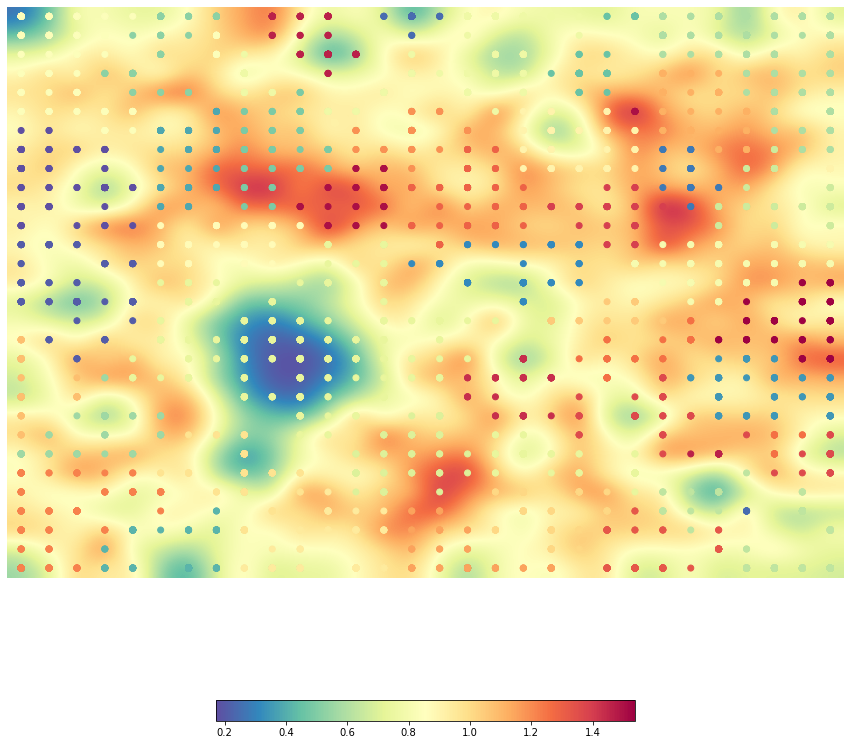

[[19 19 19 19 19 10 10 10 37 37 37 37 37  2  2  2 17 17 17 17 17  8  8 12



  12 12 12 12 12 12]



 [19 19 19 19 10 10 10 19 19 37 37 37 37  2  2  2 17 17 17 17 17  8  8 12



  12 12 12 12 12 12]



 [19 19 19 19 10 10 10 19 17 37 37 37 37 37 17 17 17 17 17 17  8  8  8 12



  12 12 12 12 12 12]



 [19 19 19 10 10 10 10 17 17 17 37 37 37 17 17 17 17 17 17  8  8  8  8 27



  27 27 12 12 12 12]



 [19 19 19 19 10 10 10 17 17 17  9 17 17 17 17 17 17 17 17  8  8  8 27 27



  27 27 12 12 12 12]



 [19 19 19 19 19  6  6  6  9  9  9 17 17 17 29 29 29 17 21 21 21 21 38 27



  27 27 27 12 12 12]



 [ 0  0 19 19 19  6  6  6  9  9  9  9 29 29 29 29 29 29 21 21 21 21 21 27



  27 27 27 12 12 12]



 [ 0  0  0  0  0  6  6  6  9  9  9  9 29 29 29 29 32 32 21 21 21 21 21  3



   3 27 27 14 12 12]



 [ 0  0  0  0  0  6  6  6  9  9  9  9 38 38 29 32 32 32 21 21 21 21 21  3



   3  3 14 14 14 21]



 [ 0  0  0  0  0  6  6  6  9  9  9 38 38 38 32 32 32 32 32 21 35 35 35  3



   3  3 14 14 

In [24]:

K=40

from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=K)
som_30.cluster(algorithm=algorithm)
som_30.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print(som_30.clusters)

print("""
Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons""")

neurons = np.zeros((2,K))
neur_tmp = [np.sum([som_30.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

In [25]:
complete_neuron_movies_report(40, som_30, ubmus_30)

Total Number of neurons in cluster 0/40 is 3201







Categories of cluster 0 are 



[('Romance Film', 278), ('Thriller', 251), ('Horror', 209), ('Drama', 190), ('Comedy', 164), ('World cinema', 143), ('Romantic comedy', 110), ('Action/Adventure', 106), ('Action', 99), ('Crime Thriller', 97), ('Musical', 88), ('Romantic drama', 88), ('Crime Fiction', 80), ('Black-and-white', 68), ('Mystery', 61), ('Indie', 60), ('Slasher', 55), ('Japanese Movies', 52), ('Psychological thriller', 43), ('Bollywood', 41), ('Silent film', 41), ('Animation', 38), ('Cult', 37), ('B-movie', 34), ('Western', 33), ('Teen', 32), ('Suspense', 31), ('Adventure', 30), ('Fantasy', 26), ('Supernatural', 23), ('Film noir', 22), ('Martial Arts Film', 21), ('Action Thrillers', 20), ('Chinese Movies', 19), ('Film adaptation', 19), ('Science Fiction', 19), ('Creature Film', 18), ('Period piece', 17), ('Television movie', 15), ('Zombie Film', 15), ('Disaster', 13), ('Family Film', 12), ('Monster movie', 12), ('Parody', 1


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [17]:
import operator

def print_categories_stats(ids):
    cat_list = []
    
    for movie in ids:
        tmp_list =  categories[movie][0].replace('"', "").split(',')
        tmp_list = [label.strip() for label in tmp_list]
        cat_list.extend(tmp_list)
    
    #unique labels frequency
    (unique, counts) = np.unique(cat_list, return_counts=True)
    frequencies  = dict(zip(unique, counts))
    frequencies = dict( sorted(frequencies.items(), key=operator.itemgetter(1),reverse=True))
    
    
    return frequencies  

Εισάγουμε 2 επιπλεον ορίσμτα, το som και το ubmus στην συνάρτηση  λόγω των πολαπλών μοντέλων που έχουμε.

In [18]:
def print_cluster_neurons_movies_report(cluster_no, som, ubmus):
    
    x,y = np.where(som.clusters==cluster_no)
    bmus_array = np.column_stack((x,y))
    neuron_indices = []

    for i in range(len(bmus_array)):
        for ubmu in ubmus:
            if bmus_array[i][0] == ubmu[0] and bmus_array[i][1]==ubmu[1]:
                neuron_indices.append(ubmu[1]*som.umatrix.shape[0] + ubmu[0]) 
                break
    return neuron_indices

In [19]:
def neuron_movies_report(neurons):
    movies_list = []
    for neuron in neurons:
        movies_list.extend(np.where(indices==neuron)[0])
    return print_categories_stats(movies_list)

Δημιουργούμε και μια επιπλέον συνάρτηση που επιστρέφει τον συνολικό αριθμό νευρώνων σε κάθε cluster καθώς και τις διάφορες κατηγοίες ταινιών του κάθε cluster, μαζί με την κατανομή των νευρώνων στις εκάστοτε κατηγορίες.

In [20]:
def complete_neuron_movies_report(clusters, som, ubmus):
    neurons = []
    for cluster in range(clusters):
        frequencies = neuron_movies_report(print_cluster_neurons_movies_report(cluster, som, ubmus))
        total_neurons = sum(frequencies.values())
        neurons.append(total_neurons)
        print("Total Number of neurons in cluster {}/{} is {}\n".format(cluster, clusters, total_neurons))
        print("Categories of cluster {} are \n{}\n".format(cluster, list(frequencies.items())))

## Σχολιασμός:


Δημιουργήσαμε 5 χάρτες SOM διαστάσεων 10x10, 15x15, 20x20, 25x25 και 30x30. Επίσης, δοκιμάσαμε clustering με τιμές k= 10, 20, 25, 30, 40. Παρατηρούμε πώς ο καλύτερος χάρτης SOM είναι αυτός που προκύπτει με διαστάσεις 30x30 και k=40. Επιλέξαμε αυτόν τον χάρτη καθώς είναι πιο ευδιάκριτος ο διαχωρισμός του επιπέδου σε μπλε-πράσινες και κόκκινες περιοχές, σε σχέση με τους προηγούμενους συνδυασμούς. Από τα 40 clusters μόνο τα 7 παρατηρούμε πώς έχουν νευρώνες στους οποίους τους έχουν ανατεθεί ταινίες.

1. Οι συχνότερες κατηγορίες παρατηρούμε πώς είναι οι drama και comedy, με τις thriller, romance film, action να εμφανίζονται επόισης πολύ συχνά στην πρώτη πεντάδα κατηγοριών. Ως λιγότερο συχνές μπορούμε  να χαρατηρήσουμε τις κατηγορίες tragedy, prison αλλά και τις κατηγορίες Tokusatsu, Wuxia, Sword and Sandal οι  οποίες εμφανίζονται σε ελάχιστα cluster (0,1) με μονοψήφιο αριθμό.

2. Παρατηρούμε πώς τα cluster 10 και 26 βρίσκονται σε απομακρυσμένα σημεία του χάρτη και δεν συνορεύουν μεταξύ τους. Οι συχνότερες κατηγορίες ταινιών ατο cluster 10 είναι οι: ('Drama', 71), ('Television movie', 15), ('Biographical film', 14), ('Musical', 10), ('Biopic', 9), ενώ στο cluster 26 οι: ('Action', 183), ('Thriller', 174), ('Mystery', 103), ('Adventure', 87), ('Drama', 77). Είναι εμφανές πώς τα οι κατηγορίες αυτών των δύο είναι cluster είναι αρτκετά δοαφορετικές.

3. Τα cluster 0 και 19 είνια γειτονικά στον χάρτη. Οι συχνότερες κατηγορίες ταινιών στο cluster 0 είναι οι: ('Romance Film', 278), ('Thriller', 251), ('Horror', 209), ('Drama', 190), ('Comedy', 164), ενώ στο cluster 19 οι: ('Drama', 780), ('Comedy', 439), ('Action', 221), ('Action/Adventure', 218), ('Thriller', 169). Οι κατηγορίες drama comedy και thriller είναι κοινές στα 2 cluster, κάτι αναμενόμενο καθώς συνορέυουν μεταξύ τους.

Ένα παράδειγμα μεγάλου cluster που δεν εμφανίζει σαφή χαρακτηριστικά είναι το 30 με 2203 κόμβους και κατηγορίες ταινιών ('Drama', 278), ('Comedy', 262), ('Black-and-white', 132), ('Documentary', 129), ('Thriller', 127), ('Romance Film', 93). Αντίστοιχο μικρό cluster με ασαφή χαρακτηριστικά δεν μπορούμε να πούμε πώς υπάρχει στο σε αυτόν τον χάρτη, καθώς τα μικρά cluster 10, 11 με 200 και 456 κόμβους αντίστοιχα έχουν αρκετά σαφή χαρακτηριστικά. Συγκεκριμένα, το cluster 10 έχει τις εξής κορυφαίες κατηγορίες ταινιών: ('Drama', 71), ('Television movie', 15), ('Biographical film', 14), ('Musical', 10), ('Biopic [feature]', 9), ('Docudrama', 9), ενώ το cluster 11 τις εξής: ('Drama', 131), ('Comedy', 90), ('War film', 41), ('Action', 27), ('World cinema', 27), ('Black comedy', 12).

Τα cluster 10 και 19 ενώ εμαφνίζονται σε πολύ κοντινές περιοχές στον χάρτη, παρατηρούμε πώς δεν έχουν κοινές κατηγορίες ταινιών. Με εξαίρεση την κατηγορία drama που είναι κοινή και για τα 2 cluster, οι υπόλοιπες είναι αρκετά διαφορετικές. Το γεγονός αυτό είναι αναμενόμενο, καθώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή. Επιπλέον δεν υπάρχει κάποια απόλυτη τοπολογία εξ ορισμού για τα κινηματογραφικά είδη, ακόμα και σε πολλές διαστάσεις, και τέλος η μείωση διαστατικότητας είναι αναμενόμενο να προκαλέσει τέτοια προβλήματα.

Τέλος, μπορούμε να εντοπίσουμε τα clusters 0, 19 και 30 τα οποία φαίνεται να έχουν τις δημοφιλέστερες κατηγορίες ταινιών.


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>